In [394]:
# ===== Standard scientific stack =====
import numpy as np
import pandas as pd

# ===== Visualization =====
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Scikit-learn (preprocessing, model selection, metrics) =====
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics

# ===== Scikit-learn (models) =====
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

# ===== StatsModels (helpers) =====
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ===== Imbalanced-learn =====
from imblearn.over_sampling import SMOTE

# ===== Pycaret =====
from pycaret.classification import setup, compare_models

# 1. 데이터 분석/데이터 전처리

In [395]:
data = pd.read_csv('lending_club_loan_two.csv')

## ① 데이터 기본 구조 확인

In [396]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [397]:
data.shape

(396030, 27)

In [398]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [399]:
# 수치형 변수 요약 통계

data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [400]:
# 범주형 변수 요약 통계

data.describe(include=['object'])

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,earliest_cr_line,initial_list_status,application_type,address
count,396030,396030,396030,373103,377729,396030,396030,396030,396030,396030,394275,396030,396030,396030,396030
unique,2,7,35,173105,11,6,3,115,2,14,48817,684,2,3,393700
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,Oct-2000,f,INDIVIDUAL,USCGC Smith\r\nFPO AE 70466
freq,302005,116018,26655,4389,126041,198348,139563,14846,318357,234507,152472,3017,238066,395319,8


## ② 결측치 & 중복치 확인

In [401]:
# 결측치 개수 확인

data.isnull().sum().sort_values(ascending=False)

mort_acc                37795
emp_title               22927
emp_length              18301
title                    1755
pub_rec_bankruptcies      535
revol_util                276
loan_amnt                   0
dti                         0
application_type            0
initial_list_status         0
total_acc                   0
revol_bal                   0
pub_rec                     0
open_acc                    0
earliest_cr_line            0
purpose                     0
term                        0
loan_status                 0
issue_d                     0
verification_status         0
annual_inc                  0
home_ownership              0
sub_grade                   0
grade                       0
installment                 0
int_rate                    0
address                     0
dtype: int64

In [402]:
# 결측처리

# 결측치 제거 (해당 컬럼 중 하나라도 NaN이면 행 전체 제거)
data = data.dropna(subset=['title', 'revol_util', 'pub_rec_bankruptcies'])

# emp_title, emp_length → 범주형 → 최빈값으로 대체
data['emp_title'].fillna(data['emp_title'].mode()[0], inplace=True)
data['emp_length'].fillna(data['emp_length'].mode()[0], inplace=True)

# mort_acc → 수치형 → 중앙값으로 대체
data['mort_acc'].fillna(data['mort_acc'].median(), inplace=True)

| 변수명 | 변수 성격 | 처리 방식 | 이유 |
|---|---|---|---|
| `title` | 차주가 작성한 **대출 제목** (문자열) | **결측치가 있는 행 삭제** | 분석·예측에서 비중이 크지 않고 결측치 비율이 낮아, 삭제해도 전체 데이터에 미치는 **영향이 작음** |
| `revol_util` | **수치형** (리볼빙 한도 대비 사용률) | **결측치가 있는 행 삭제** | 신용위험 예측에서 **매우 중요한 변수**로, 임의 대체 시 왜곡 위험이 큼. **결측치 비중이 적어 삭제가 더 안전** |
| `pub_rec_bankruptcies` | **수치형** (파산 공공기록 수) | **결측치가 있는 행 삭제** | 파산 이력은 위험 예측의 **강력한 신호**. 임의 대체는 오신호 가능. **결측치가 소수**이므로 삭제가 **정보 손실 최소화** |
| `emp_title` | **범주형** (직함, 문자열 다양) | **최빈값(mode) 대체** | 직함 정보는 값 종류가 매우 다양하고 결측도 발생 가능. 결측 행을 삭제하면 데이터 손실이 큼 → **최빈값 대체로 정보 손실 최소화** |
| `emp_length` | **범주형** (재직기간) | **최빈값(mode) 대체** | 재직기간은 심사에서 중요하지만 범주형(`0~10년` 등)이라 **최빈값으로 채워도 분포 왜곡이 작음** |
| `mort_acc` | **수치형** (모기지 계좌 수) | **중앙값(median) 대체** | 값이 **0~2개에 치우친 분포**로 이상치 영향이 큼. 평균보다 **중앙값이 이상치에 강건**하고 전체 분포를 더 잘 반영 |

In [403]:
# 결측치 확인

data.isnull().sum().sort_values(ascending=False)

loan_amnt               0
title                   0
pub_rec_bankruptcies    0
mort_acc                0
application_type        0
initial_list_status     0
total_acc               0
revol_util              0
revol_bal               0
pub_rec                 0
open_acc                0
earliest_cr_line        0
dti                     0
purpose                 0
term                    0
loan_status             0
issue_d                 0
verification_status     0
annual_inc              0
home_ownership          0
emp_length              0
emp_title               0
sub_grade               0
grade                   0
installment             0
int_rate                0
address                 0
dtype: int64

In [404]:
# 중복 행 개수 확인

dup_count = data.duplicated().sum()
print(f"\n중복 행 개수: {dup_count}")


중복 행 개수: 0


## ③ 수치형 변수 분석

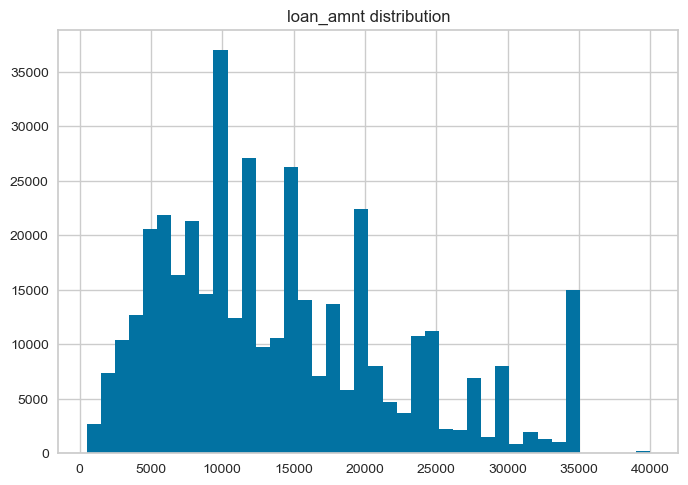

In [405]:
# loan_amnt(대출금액)

data['loan_amnt'].hist(bins=40)
plt.title('loan_amnt distribution')
plt.show()

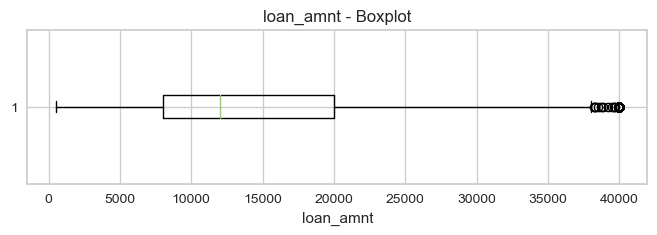

In [406]:
plt.figure(figsize=(8, 2))
plt.boxplot(data['loan_amnt'].dropna(), vert=False)
plt.title('loan_amnt - Boxplot')
plt.xlabel('loan_amnt')
plt.show()

###  Loan Amount Distribution

- 대출 금액은 **0 ~ 40,000달러** 구간에 분포하고 있다.  
- **5,000 ~ 15,000달러** 구간에 데이터가 가장 많이 몰려 있으며, 특히 10,000달러 부근에서 뚜렷한 봉우리(peak)가 관찰된다.  
- 오른쪽으로 꼬리가 긴 형태(right-skewed)로, **30,000~40,000달러의 고액 대출**도 일부 존재한다.  
- 이러한 분포는 금융기관의 **표준 대출 금액 단위**(예: 5,000달러, 10,000달러 등)에 따라 형성된 것으로 보인다.


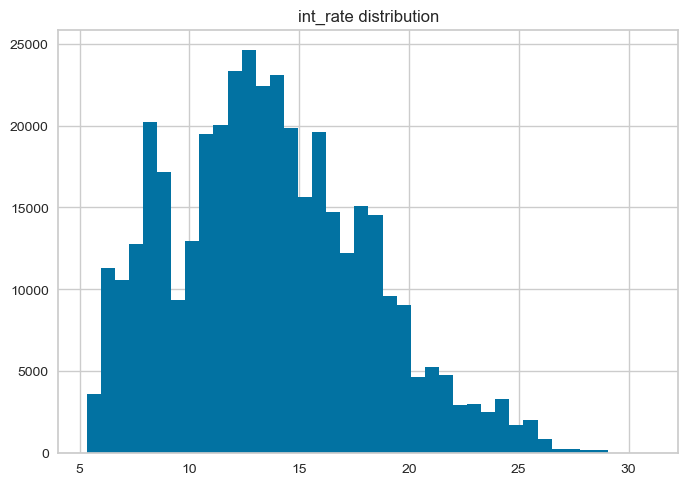

In [407]:
# int_rate(이자율)

data['int_rate'].hist(bins=40)
plt.title('int_rate distribution')
plt.show()

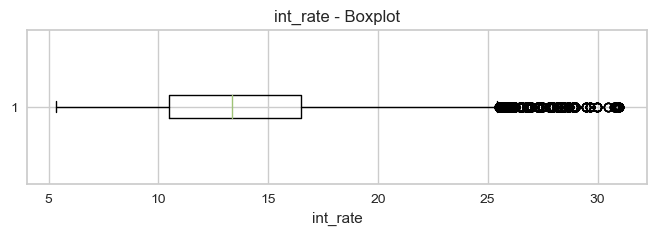

In [408]:
plt.figure(figsize=(8, 2))
plt.boxplot(data['int_rate'].dropna(), vert=False)
plt.title('int_rate - Boxplot')
plt.xlabel('int_rate')
plt.show()

###  Interest Rate Distribution

- 이자율은 **5% ~ 30%** 구간에 분포한다.  
- **10% ~ 15% 구간에 대출이 가장 많이 몰려 있으며**, 분포의 중심이 이 구간에 위치해 있다.  
- 전체적으로 오른쪽 꼬리가 긴 형태(right-skewed)로, **20% 이상의 고이자 대출**도 소수 존재한다.  
- 이자율이 높을수록 신용도가 낮은 차주일 가능성이 크며, 신용등급(grade)과 밀접한 상관이 있을 것으로 예상된다.


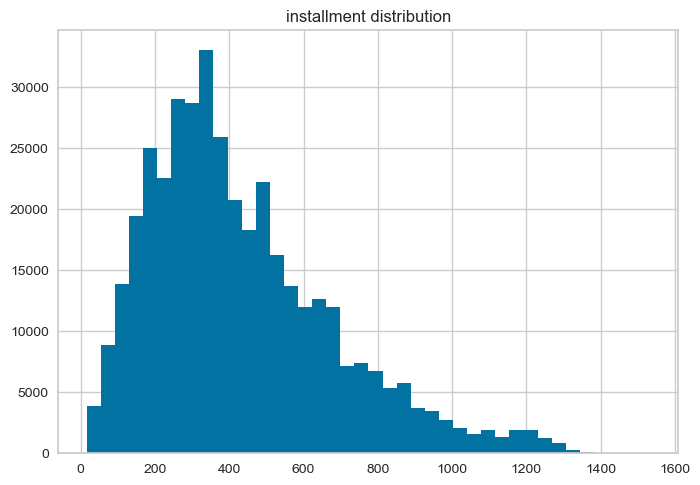

In [409]:
# installment(월 상환액)

data['installment'].hist(bins=40)
plt.title('installment distribution')
plt.show()

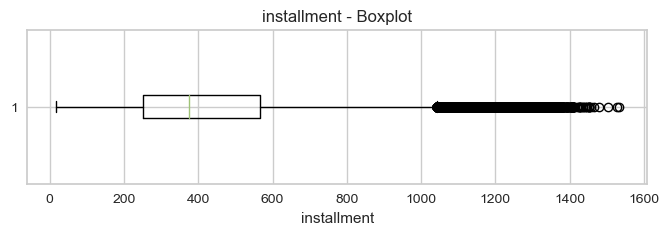

In [410]:
plt.figure(figsize=(8, 2))
plt.boxplot(data['installment'].dropna(), vert=False)
plt.title('installment - Boxplot')
plt.xlabel('installment')
plt.show()

###  Installment Distribution

- 월 상환액(installment)은 **0 ~ 1,500달러** 범위에 분포한다.  
- **200 ~ 400달러 구간**에 데이터가 가장 많이 몰려 있으며, 분포의 중심도 이 구간에 위치해 있다.  
- 오른쪽으로 꼬리가 긴 형태(right-skewed)를 보이며, **1,000달러 이상의 고액 상환** 사례는 소수 존재한다.  
- 이는 대부분의 차주가 중간 수준의 월 상환액을 부담하는 대출을 받고 있음을 보여준다.


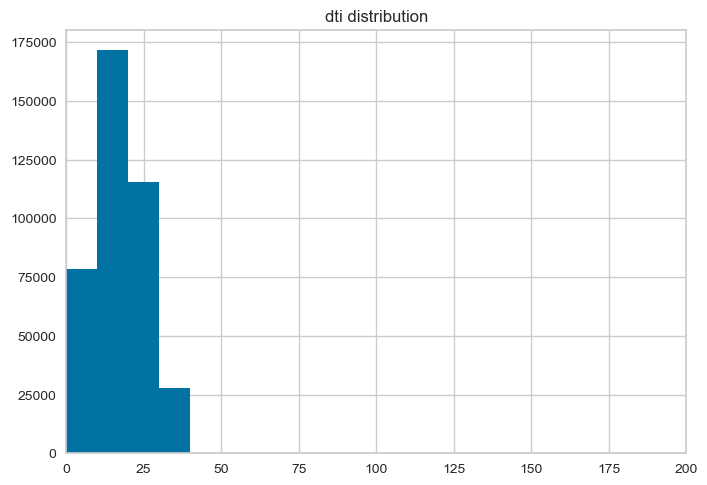

In [411]:
# dti(부채상환비율)

data['dti'].hist(bins=1000)
plt.xlim(0, 200)
plt.title('dti distribution')
plt.show()

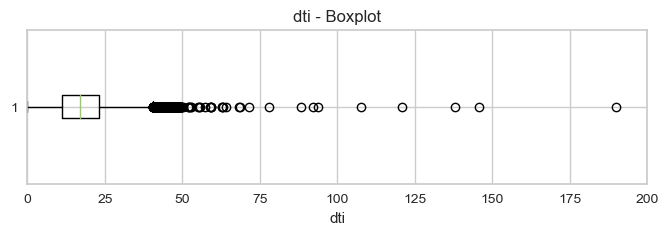

In [412]:
plt.figure(figsize=(8, 2))
plt.boxplot(data['dti'].dropna(), vert=False)
plt.xlim(0,200)
plt.title('dti - Boxplot')
plt.xlabel('dti')
plt.show()

### DTI Distribution

- DTI 값은 대부분 **10 ~ 25** 구간에 집중되어 있다.  
- 특히 **0 ~ 25** 구간에 대출이 몰려 있으며, 그 이상 구간에서는 급격히 빈도가 줄어든다.  
- 오른쪽으로 꼬리가 있는 형태(right-skewed)를 보이며, 극단적으로 큰 값은 거의 존재하지 않는다.  
- 이는 대부분의 차주가 상대적으로 낮은 부채상환비율을 가지고 있음을 보여준다.


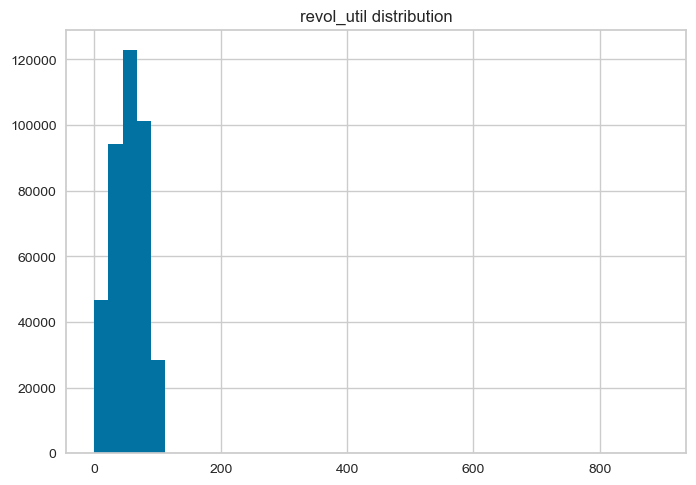

In [413]:
# revol_util(리볼빙 한도 대비 사용률)

data['revol_util'].hist(bins=40)
plt.title('revol_util distribution')
plt.show()

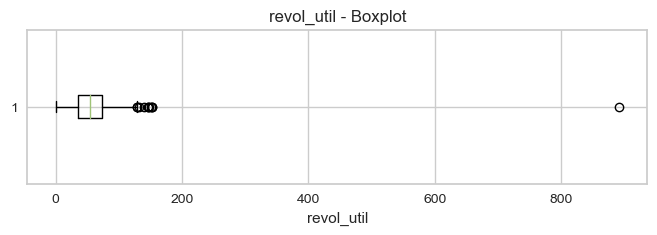

In [414]:
plt.figure(figsize=(8, 2))
plt.boxplot(data['revol_util'].dropna(), vert=False)
plt.title('revol_util - Boxplot')
plt.xlabel('revol_util')
plt.show()

### Revolving Utilization Rate Distribution

- **0 ~ 100% 구간**에 데이터가 집중되어 있으며, 40~60% 부근에서 봉우리가 나타난다.  
- 100%를 초과하는 고사용률 값도 일부 존재하지만 빈도는 낮다.  
- 이는 많은 차주가 신용한도의 절반 전후로 리볼빙을 사용하는 반면, 일부는 한도를 초과하는 고위험 상태임을 보여준다.

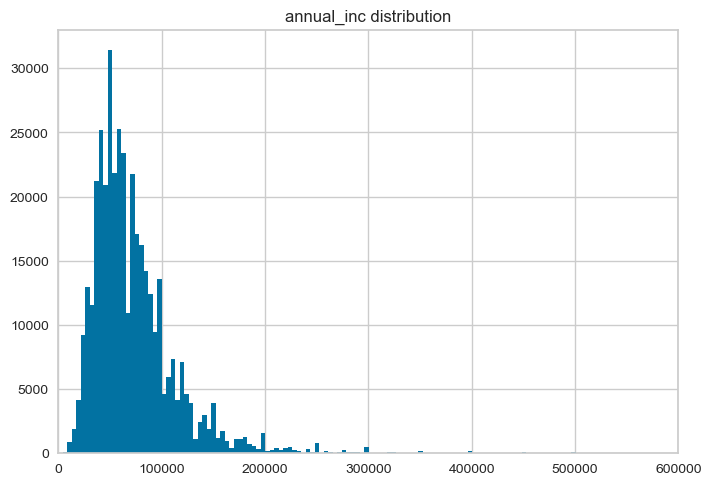

In [415]:
# annual_inc(연소득)

data['annual_inc'].hist(bins=2000)
plt.xlim(0, 600000)
plt.title('annual_inc distribution')
plt.show()

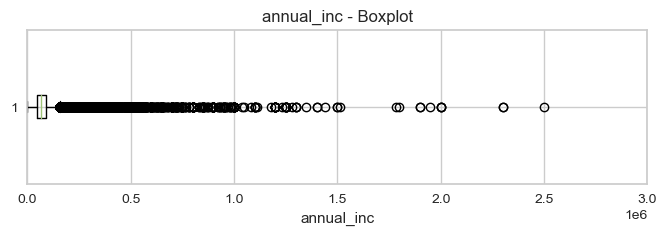

In [416]:
plt.figure(figsize=(8, 2))
plt.boxplot(data['annual_inc'].dropna(), vert=False)
plt.xlim(0, 3000000)
plt.title('annual_inc - Boxplot')
plt.xlabel('annual_inc')
plt.show()

### Annual Income Distribution

- 대부분의 차주가 **2만 ~ 10만 달러** 사이의 소득을 가지고 있으며, 5만 달러 부근에서 뚜렷한 봉우리가 나타난다.

- 소득이 10만 달러를 넘는 고소득자도 존재하지만, 빈도는 점차 줄어드는 형태로  
오른쪽으로 긴 꼬리(right-skewed)를 가진 분포다.

- 이는 소수의 고소득 차주가 전체 분포를 비대칭적으로 만들고 있다. --> 모델링 시 로그 변환 등을 통해 스케일 안정화


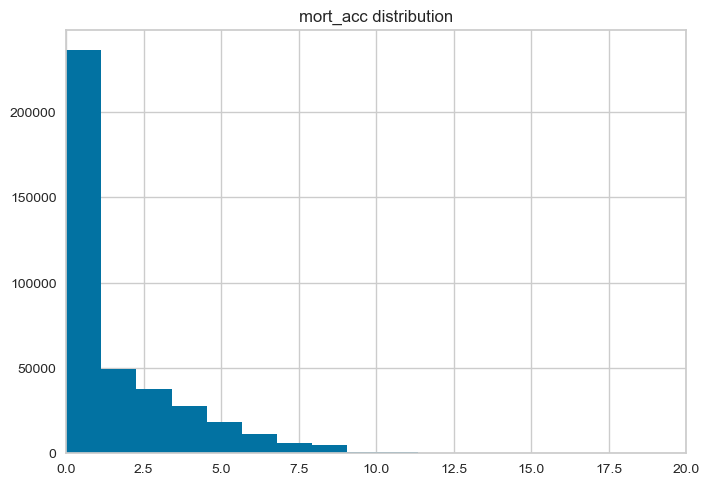

In [417]:
# mort_acc(모기지 계좌수)

data['mort_acc'].hist(bins=30)
plt.xlim(0,20)
plt.title('mort_acc distribution')
plt.show()

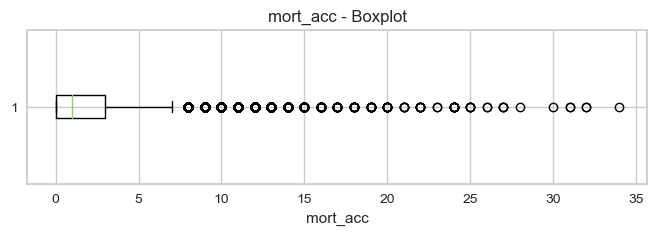

In [418]:
plt.figure(figsize=(8, 2))
plt.boxplot(data['mort_acc'].dropna(), vert=False)
plt.title('mort_acc - Boxplot')
plt.xlabel('mort_acc')
plt.show()

### Mortgage Accounts Distribution

- 대부분의 차주는 **0~2개의 모기지 계좌**를 보유하고 있으며, 특히 **0개 계좌**가 압도적으로 많다.

- 3개 이상을 보유한 차주는 급격히 줄어들고, 10개 이상은 매우 드물다. 분포는 오른쪽으로 긴 꼬리(right-skewed) 형태를 띤다.

- 이는 대부분의 차주가 모기지 계좌가 거의 없거나 1~2개 수준이며, 다수의 모기지를 보유한 차주는 소수임을 보여준다.


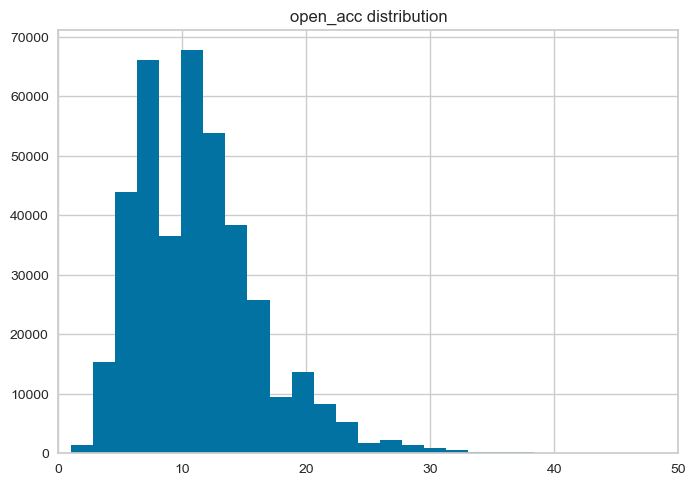

In [419]:
# open_acc(현재 개설된 신용계좌 수)

data['open_acc'].hist(bins=50)
plt.xlim(0, 50)
plt.title('open_acc distribution')
plt.show()

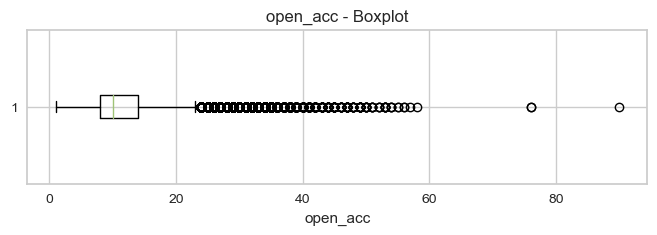

In [420]:
plt.figure(figsize=(8, 2))
plt.boxplot(data['open_acc'].dropna(), vert=False)
plt.title('open_acc - Boxplot')
plt.xlabel('open_acc')
plt.show()

###  Open Credit Lines Distribution

- 대부분의 차주는 **5~15개 사이**의 신용계좌를 보유하고 있으며, 특히 **10개 부근**에서 가장 높은 빈도를 보인다.

- 20개 이상의 계좌를 가진 경우는 점차 줄어들며, 30개 이상은 드물다. 전체적으로 **오른쪽으로 긴 꼬리(right-skewed)** 분포를 보인다.

- 이는 대부분의 차주가 중간 수준(약 10개)의 신용계좌를 가지고 있고, 계좌 수가 비정상적으로 많은 차주는 소수임을 시사한다.


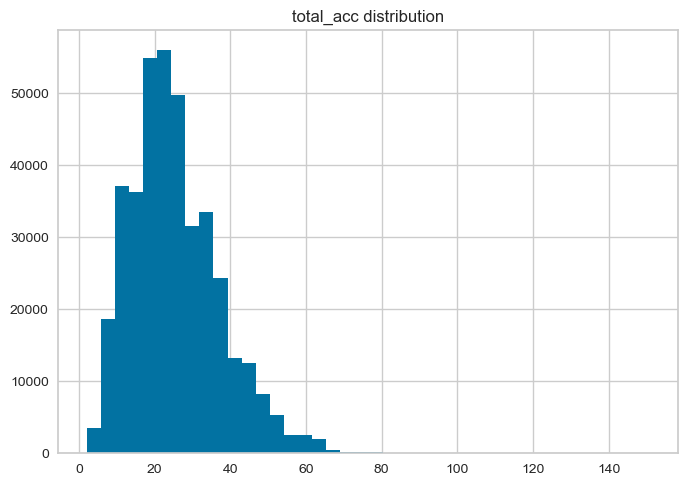

In [421]:
# total_acc(누적 신용계좌 총)

data['total_acc'].hist(bins=40)
plt.title('total_acc distribution')
plt.show()

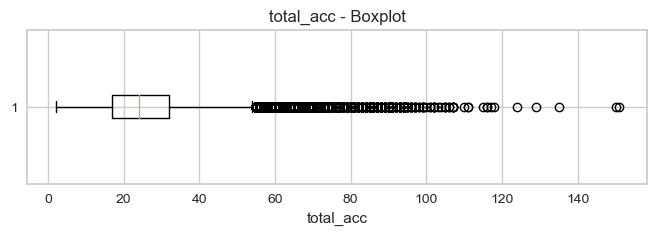

In [422]:
plt.figure(figsize=(8, 2))
plt.boxplot(data['total_acc'].dropna(), vert=False)
plt.title('total_acc - Boxplot')
plt.xlabel('total_acc')
plt.show()

###  Total Credit Accounts Distribution

- 대부분의 차주는 **10~30개 사이**의 누적 신용계좌를 가지고 있으며, 특히 **20개 부근**에서 가장 빈도가 높다.

- 40개 이상의 계좌를 보유한 경우는 점점 줄어들며, 80개 이상은 매우 드물다. 분포는 **오른쪽으로 긴 꼬리(right-skewed)** 형태를 띠고 있다.

- 이는 대부분의 차주가 중간 수준의 신용활동 이력을 가지고 있으며, 비정상적으로 많은 신용계좌를 가진 차주는 소수임을 보여준다.


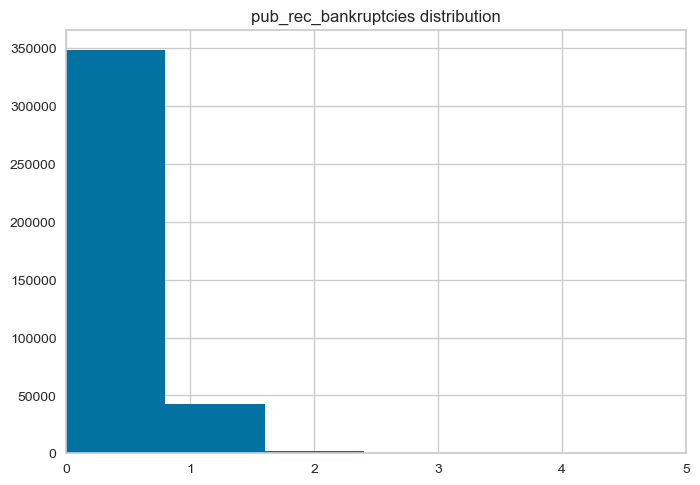

In [423]:
#  pub_rec_bankruptcies(파산 공공기록 수)

data['pub_rec_bankruptcies'].hist(bins=10)
plt.xlim(0,5)
plt.title('pub_rec_bankruptcies distribution')
plt.show()

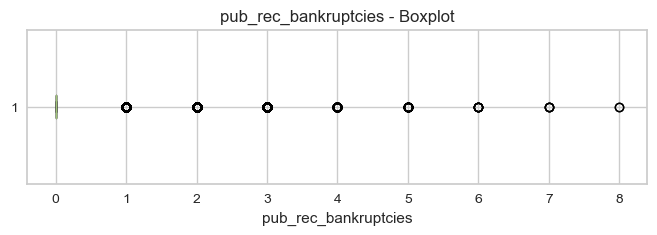

In [424]:
plt.figure(figsize=(8, 2))
plt.boxplot(data['pub_rec_bankruptcies'].dropna(), vert=False)
plt.title('pub_rec_bankruptcies - Boxplot')
plt.xlabel('pub_rec_bankruptcies')
plt.show()

### Public Record Bankruptcies  Distribution

- 대부분의 차주는 **파산 기록이 0건**이며, 1건 이상을 가진 경우는 매우 드물다. 특히 2건 이상의 파산 기록을 가진 차주는 극히 적은 비중을 차지한다.

- 이는 파산 기록이 있는 차주가 소수이며, 대부분의 차주가 신용상 파산 이력이 없다는 점을 보여준다.  

## ④ 이상치 처리

In [425]:
def treat_outlier(df,feature):
    Q3 = df[feature].quantile(0.75)
    Q1 = df[feature].quantile(0.25)
    IQR = Q3-Q1
    upper = Q3+(1.5*IQR)
    lower = Q1-(1.5*IQR)
    print(feature,upper,lower)
    df = df[(df[feature]>lower) & (df[feature]<upper)]
    return df

loan_amnt 11.27786115894024 7.612998205196056


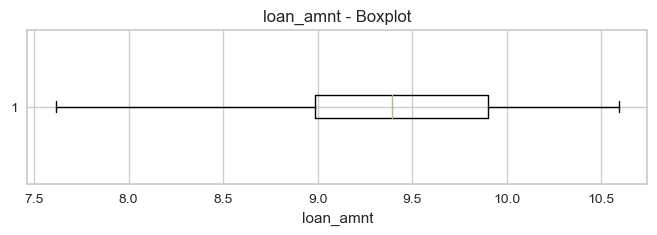

In [426]:
# loan_amnt

data['loan_amnt'] = data['loan_amnt'].apply(np.log1p)  # 로그변환(np.log(1+x)를 쓰는 게 매우 작은 값도 안전하게 변환함)
data = treat_outlier(data,'loan_amnt')

# 결측치 제거 후, 박스플롯

plt.figure(figsize=(8, 2))
plt.boxplot(data['loan_amnt'].dropna(), vert=False)
plt.title('loan_amnt - Boxplot')
plt.xlabel('loan_amnt')
plt.show()

int_rate 25.489999999999995 1.4900000000000038


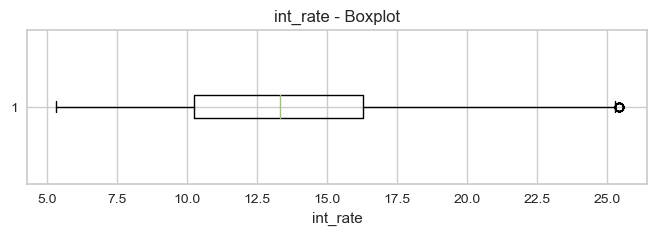

In [427]:
# int_rate

data = treat_outlier(data,'int_rate')

# 결측치 제거 후, 박스플롯

plt.figure(figsize=(8, 2))
plt.boxplot(data['int_rate'].dropna(), vert=False)
plt.title('int_rate - Boxplot')
plt.xlabel('int_rate')
plt.show()

installment 1039.6799999999998 -211.43999999999994


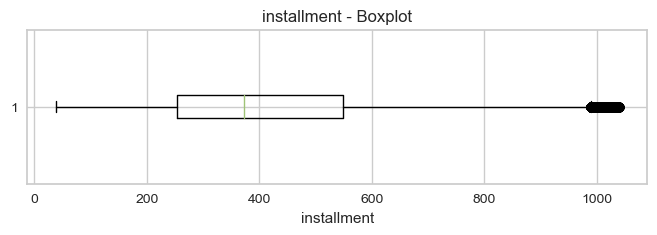

In [428]:
# installment

data = treat_outlier(data,'installment')

# 결측치 제거 후, 박스플롯

plt.figure(figsize=(8, 2))
plt.boxplot(data['installment'].dropna(), vert=False)
plt.title('installment - Boxplot')
plt.xlabel('installment')
plt.show()

dti 40.5 -6.219999999999999


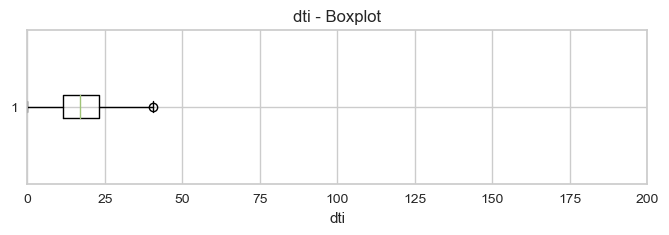

In [429]:
# dti

data = treat_outlier(data,'dti')

# 결측치 제거 후, 박스플롯

plt.figure(figsize=(8, 2))
plt.boxplot(data['dti'].dropna(), vert=False)
plt.xlim(0,200)
plt.title('dti - Boxplot')
plt.xlabel('dti')
plt.show()

revol_util 127.79999999999998 -19.4


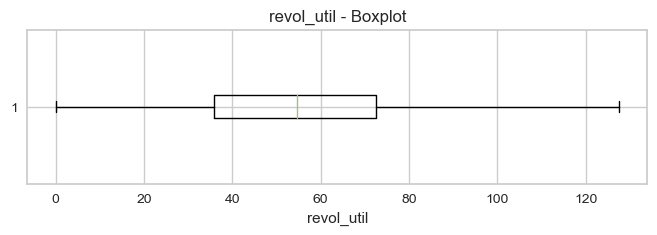

In [430]:
# revol_util

data['revol_bal'] = data['revol_bal'].apply(np.sqrt) # 소수의 차주가 매우 높은 값을 가지는 치우친 분포 -> 정상적인 값들이 이상치로 잡힐 수 있음
data = treat_outlier(data,'revol_util')

# 결측치 제거 후, 박스플롯

plt.figure(figsize=(8, 2))
plt.boxplot(data['revol_util'].dropna(), vert=False)
plt.title('revol_util - Boxplot')
plt.xlabel('revol_util')
plt.show()

annual_inc 12.376853766037922 9.716991725541678


Text(0.5, 1.0, 'annual_inc - Boxplot')

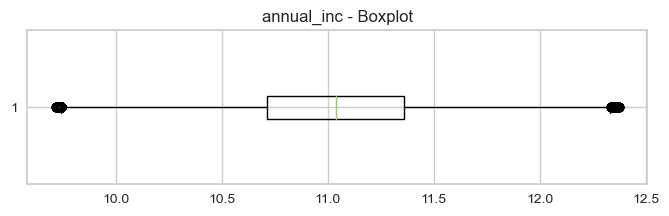

In [431]:
# annual_inc

data['annual_inc'] = data['annual_inc'].apply(np.log1p)  # 로그변환(np.log(1+x)를 쓰는 게 매우 작은 값도 안전하게 변환함)
data = treat_outlier(data,'annual_inc')

# 결측치 제거 후, 박스플롯

plt.figure(figsize=(8, 2))
plt.boxplot(data['annual_inc'].dropna(), vert=False)
plt.title('annual_inc - Boxplot')

mort_acc 7.5 -4.5


{'whiskers': [<matplotlib.lines.Line2D at 0x16ca670fb90>,
 'caps': [<matplotlib.lines.Line2D at 0x16ca670ced0>,
 'boxes': [<matplotlib.lines.Line2D at 0x16c2c1cb390>],
 'medians': [<matplotlib.lines.Line2D at 0x16c2c2ceb90>],
 'fliers': [<matplotlib.lines.Line2D at 0x16c2c2c3c50>],
 'means': []}

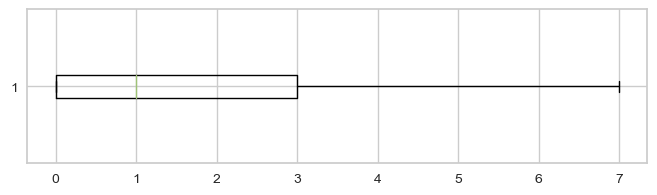

In [432]:
# mort_acc

data = treat_outlier(data,'mort_acc')

# 결측치 제거 후, 박스플롯

plt.figure(figsize=(8, 2))
plt.boxplot(data['mort_acc'].dropna(), vert=False)

open_acc 23.0 -1.0


{'whiskers': [<matplotlib.lines.Line2D at 0x16ca6abb6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x16ca6abaad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x16ca6ab9910>],
 'medians': [<matplotlib.lines.Line2D at 0x16c2be59390>],
 'fliers': [<matplotlib.lines.Line2D at 0x16ca8eb3850>],
 'means': []}

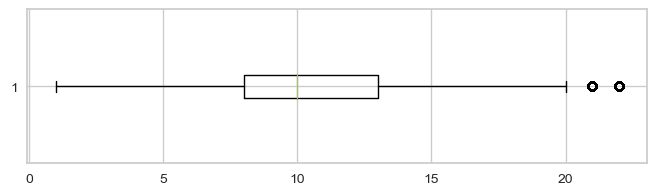

In [433]:
# open_acc

data = treat_outlier(data,'open_acc')

# 결측치 제거 후, 박스플롯

plt.figure(figsize=(8, 2))
plt.boxplot(data['open_acc'].dropna(), vert=False)

total_acc 53.5 -6.5


{'whiskers': [<matplotlib.lines.Line2D at 0x16cae4f5c90>,
 'caps': [<matplotlib.lines.Line2D at 0x16cae4f7c90>,
 'boxes': [<matplotlib.lines.Line2D at 0x16cae4f6fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x16cacc51410>],
 'fliers': [<matplotlib.lines.Line2D at 0x16ca6ab9950>],
 'means': []}

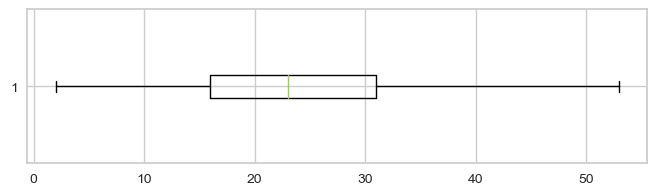

In [434]:
# total_acc

data = treat_outlier(data,'total_acc')

# 결측치 제거 후, 박스플롯

plt.figure(figsize=(8, 2))
plt.boxplot(data['total_acc'].dropna(), vert=False)

## ⑤ 범주형 변수 분석

In [435]:
data.select_dtypes(include=['object', 'category']).columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

 36 months    261388
 60 months     81845
Name: term, dtype: int64


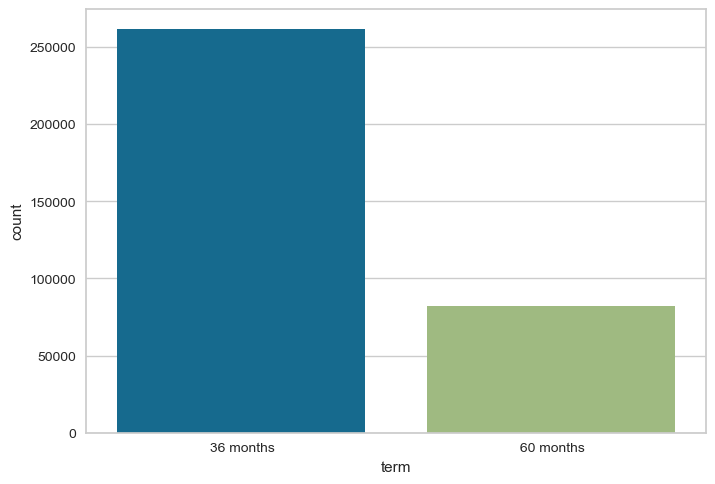

In [436]:
# term

print(data['term'].value_counts())

sns.countplot(data=data,x='term')
plt.show()

### term

- 대출 기간은 36개월과 60개월로 구분되며, **36개월 대출이 훨씬 많다**

B    103648
C     91937
A     57150
D     54205
E     26765
F      9031
G       497
Name: grade, dtype: int64


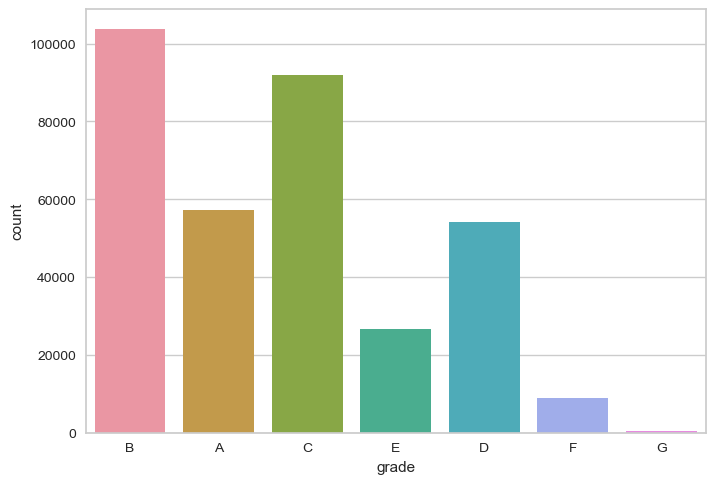

In [437]:
# grade

print(data['grade'].value_counts())

sns.countplot(data=data,x='grade')
plt.show()

### grade

- 대출 등급은 **B, C 등급이 가장 많고**, F와 G 등급은 매우 적다.  

B3    23848
B4    22921
C1    20838
B2    19991
B5    19729
C2    19621
C3    18297
C4    17527
B1    17159
A5    16441
C5    15654
A4    14067
D1    13749
D2    11984
D3    10425
D4     9935
A3     9439
A1     8680
A2     8523
D5     8112
E1     6695
E2     6258
E3     5272
E4     4599
E5     3941
F1     2903
F2     2346
F3     1940
F4     1450
F5      392
G1      209
G2      127
G3       74
G4       51
G5       36
Name: sub_grade, dtype: int64


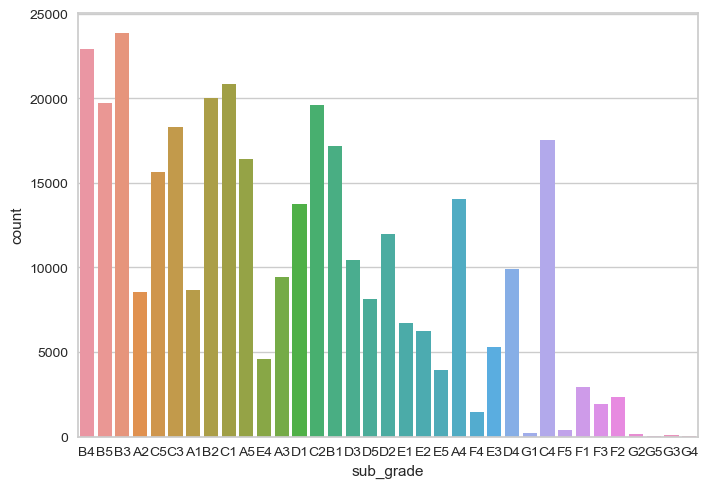

In [438]:
# sub_grade

print(data['sub_grade'].value_counts())

sns.countplot(data=data,x='sub_grade')
plt.show()

### sub_grade

- 세부 등급(sub_grade)은 전반적으로 **B 등급군이 가장 많고**, G 등급군은 매우 적다.  
- 특히 **B4, B5, C3, C4** 등에서 높은 빈도가 나타나며, **G3, G4** 등은 거의 존재하지 않는다.  
- 이는 대출 등급의 세분화된 분포가 상위 등급에 집중되어 있음을 보여준다.

In [439]:
# emp_title

(data['emp_title'].value_counts(normalize=True)*100).head(10)

Teacher             6.611544
Manager             1.064292
Supervisor          0.464408
Registered Nurse    0.444013
RN                  0.437312
Sales               0.405264
Project Manager     0.371759
Driver              0.349617
Owner               0.329222
Office Manager      0.312324
Name: emp_title, dtype: float64

### emp_title

- 직업명(emp_title) 상위 10개를 보면 Teacher(교사)가 약 6.6%로 가장 높은 비중을 차지하고 있음  
- 그 외에는 Manager, Supervisor, Registered Nurse 등이 소수의 비중을 차지함  
- 전체적으로 직업 분포가 **특정 직군에 집중되지 않고 다양하게 분포**되어 있음을 확인할 수 있음


10+ years    122943
2 years       31173
3 years       27657
< 1 year      27372
5 years       23400
1 year        22539
4 years       20987
6 years       18449
7 years       18404
8 years       16840
9 years       13469
Name: emp_length, dtype: int64


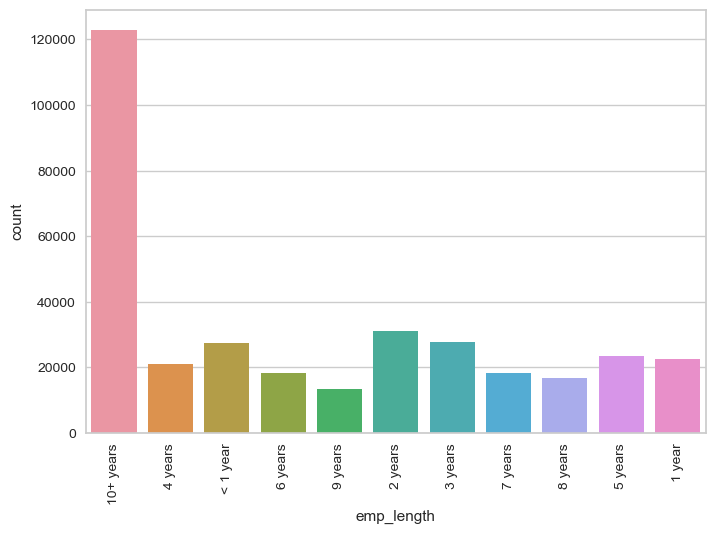

In [440]:
# emp_length

print(data['emp_length'].value_counts())

sns.countplot(data=data,x='emp_length')
plt.xticks(rotation=90)
plt.show()

### emp_length

- **10년 이상 근무(10+ years)** 항목이 가장 많으며, 약 12만 건 이상으로 다른 구간에 비해 매우 높은 비중을 차지함  

MORTGAGE    168675
RENT        142213
OTHER        32345
Name: home_ownership, dtype: int64


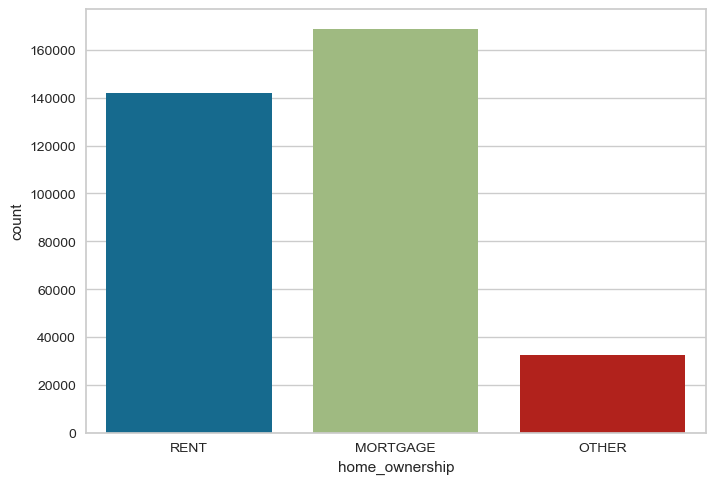

In [441]:
# 'home_ownership

def categorize_home_ownership(x):     # 범주 줄이기
    if(x=='MORTGAGE' or x=='RENT'):
        return x
    return 'OTHER'

data['home_ownership'] = data['home_ownership'].apply(categorize_home_ownership)

print(data['home_ownership'].value_counts())

sns.countplot(data=data,x='home_ownership')
plt.show()

### home_ownership

- **MORTGAGE(주택담보)** 보유자가 약 168,000건으로 가장 많음  
- RENT(임차)는 약 142,000건으로 두 번째로 많고,  
- OTHER(기타)는 상대적으로 적은 약 32,000건 수준임  
- 전체적으로 **주택담보 보유자와 임차인이 대부분을 차지**하고 있음


Verified           115655
Source Verified    114654
Not Verified       112924
Name: verification_status, dtype: int64


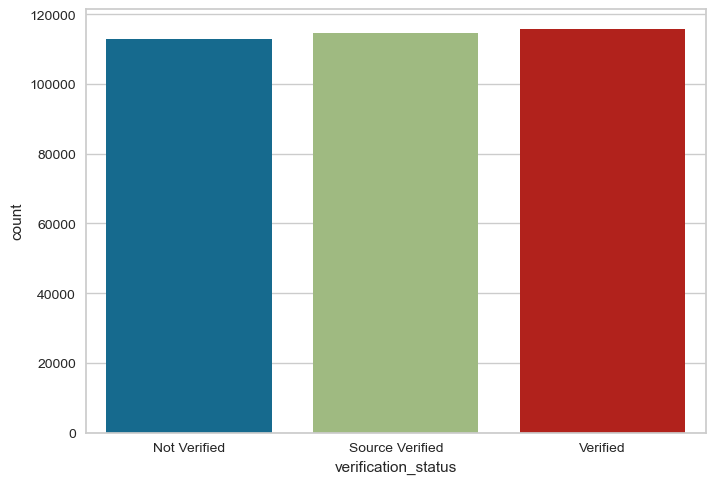

In [442]:
# verification_status

print(data['verification_status'].value_counts())

sns.countplot(data=data,x='verification_status')
plt.show()

### verification_status

- **Verified**, **Source Verified**, **Not Verified** 세 그룹이 모두 약 11만 건대로 비슷한 분포를 보임  
- 세 그룹 간 큰 차이는 없으며, **검증 여부에 따라 대출자 수가 고르게 분포**되어 있음


2014    88847
2013    87139
2015    80248
2012    37170
2016    21199
2011    15981
2010     8389
2009     3455
2008      800
2007        5
Name: issue_d_year, dtype: int64


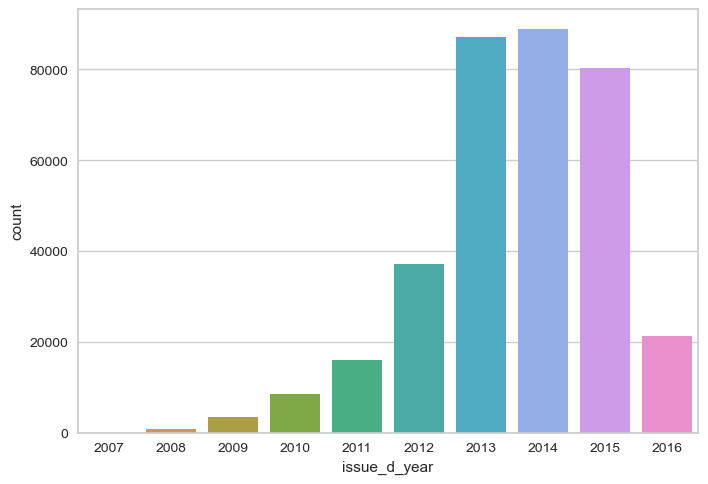

In [443]:
# issue_d

data['issue_d'] = pd.to_datetime(data['issue_d'])
data['issue_d_year'] = data['issue_d'].dt.year
data['issue_d_month'] = data['issue_d'].dt.month
data.drop(columns=['issue_d'],inplace=True)

# issue_d_year

print(data['issue_d_year'].value_counts())
sns.countplot(data=data,x='issue_d_year')
plt.show()

### issue_d_year

- 2007~2011년까지는 발급 건수가 적었으나 **2012년 이후 급격히 증가**  
- **2013~2014년에 가장 많은 대출이 발급**되었으며, 이후 2015년에 다소 감소, 2016년에는 데이터가 일부만 존재  
- 대출 시장의 **활성화 시점을 파악**할 수 있는 변수


10    36734
7     34695
1     29751
11    29706
4     28779
8     28345
5     27816
3     27229
6     26360
12    25028
2     24642
9     24148
Name: issue_d_month, dtype: int64


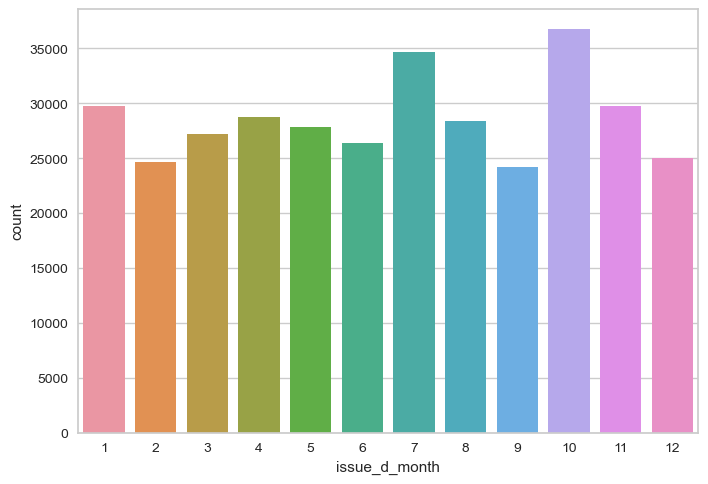

In [444]:
# issue_d_month

print(data['issue_d_month'].value_counts())

sns.countplot(data=data,x='issue_d_month')
plt.show()

### issue_d_month

- 월별 대출 발급 건수는 **큰 차이는 없으나**, 7월과 10월에 다소 많음  
- 2월과 12월은 상대적으로 적은 편  
- 특정 월에 집중된 대출은 없으며, **전반적으로 고르게 분포**


Fully Paid     276287
Charged Off     66946
Name: loan_status, dtype: int64


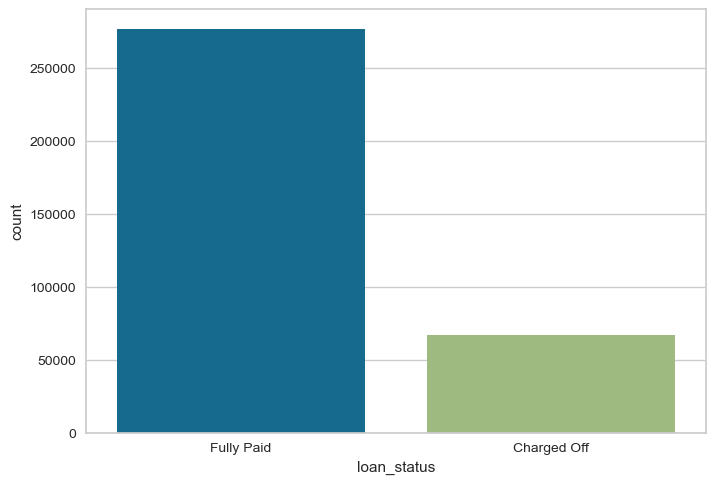

In [445]:
# loan_status

print(data['loan_status'].value_counts())

sns.countplot(data=data,x='loan_status')
plt.show()

### loan_status

- **정상 상환(Fully Paid)** 건수가 약 27만 건으로 대부분을 차지  
- **부실(Charged Off)** 건수는 약 6.6만 건으로 상대적으로 적음  
- 데이터가 **불균형(imbalanced)** 상태이므로, 모델 학습 시 이에 대한 처리가 필요함 (예: SMOTE)


debt_consolidation    205299
credit_card            73169
other                  64765
Name: purpose, dtype: int64


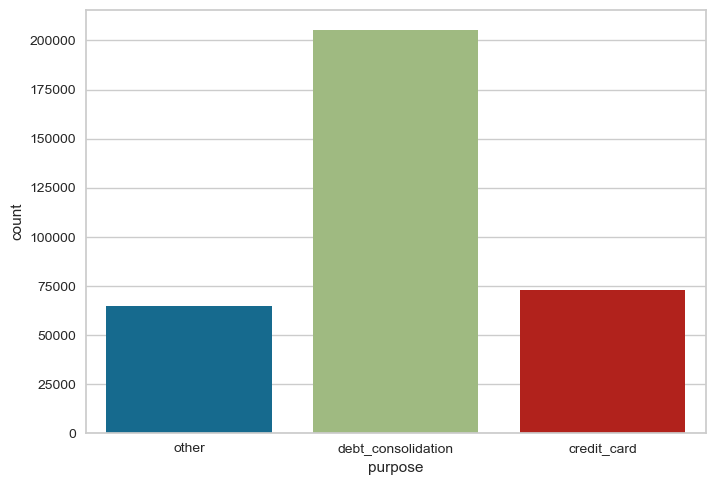

In [446]:
# purpose

def categorize_purpose(x):   # 범주 줄이기
    if(x =='debt_consolidation' or  x =='credit_card'):
        return x
    return 'other'

data['purpose'] = data['purpose'].apply(categorize_purpose)

print(data['purpose'].value_counts())

sns.countplot(data=data,x='purpose')
plt.show()

### purpose

- **debt_consolidation** 목적이 약 20만 건으로 가장 많음  
- **credit_card** 목적은 약 7만 건, **other** 목적은 약 6.4만 건 정도임  
- 목적 변수는 세 가지 범주로 단순화하여 시각화함


In [447]:
# title

data['title'].value_counts()

Debt consolidation         131841
Credit card refinancing     44719
Home improvement            12548
Other                       10443
Debt Consolidation          10417
                            ...  
moving on up                    1
godsent                         1
Paydown Credit Cards            1
Station Park Honda              1
Loanforpayoff                   1
Name: title, Length: 44093, dtype: int64

### title

- 대출 제목은 총 43,936개의 고유값을 가짐  
- **Debt consolidation** 관련 제목이 가장 많으며, 약 13만 건  
- 그 외 **Credit card refinancing**, **Home improvement** 등이 뒤를 이음  
- `title` 변수는 대출 목적(`purpose`)과 거의 동일한 정보를 담고 있어 **중복 변수**에 해당함  
- 고유값이 지나치게 많아 모델에 불필요한 차원을 추가할 수 있음  
- 따라서 데이터 정제 과정에서 삭제함

In [448]:
data.drop(columns=['title'],inplace=True)

2000    25756
2001    25639
1999    23061
2002    22937
2003    21126
        ...  
1954        4
1951        3
1950        3
1944        1
1953        1
Name: earliest_cr_line_year, Length: 64, dtype: int64


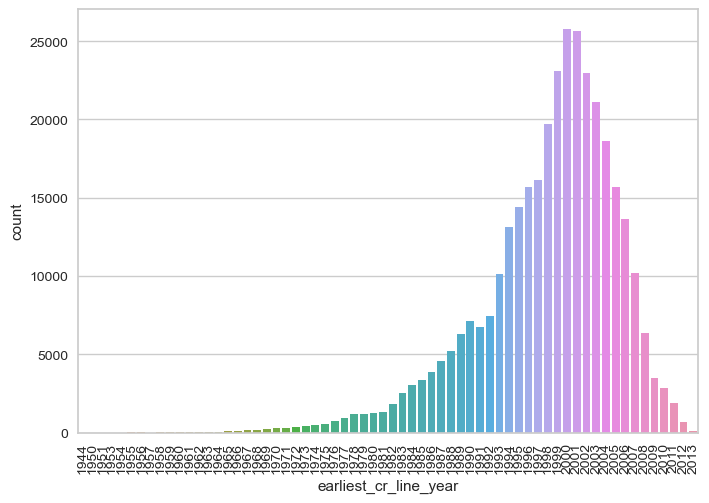

In [449]:
# earliest_cr_line

data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
data['earliest_cr_line_year'] = data['earliest_cr_line'].dt.year
data['earliest_cr_line_month'] = data['earliest_cr_line'].dt.month
data.drop(columns=['earliest_cr_line'],inplace=True)

# earliest_cr_line_year

print(data['earliest_cr_line_year'].value_counts())

sns.countplot(data=data,x='earliest_cr_line_year')
plt.xticks(rotation=90)
plt.show()

### earliest_cr_line_year

- 신용 계좌 개설 연도를 나타내는 변수로, 1950년대부터 2016년까지 분포함  
- 2000년대 중반 이후 계좌를 개설한 비중이 급격히 증가하여, **2000~2010년대에 집중적으로 분포**  
- 데이터 초기에 해당하는 연도(1950~1970년대)는 관측값이 매우 적음


10    33203
9     32627
8     32372
11    30844
12    29427
7     27756
3     27298
1     26639
5     26343
6     26325
4     25231
2     25168
Name: earliest_cr_line_month, dtype: int64


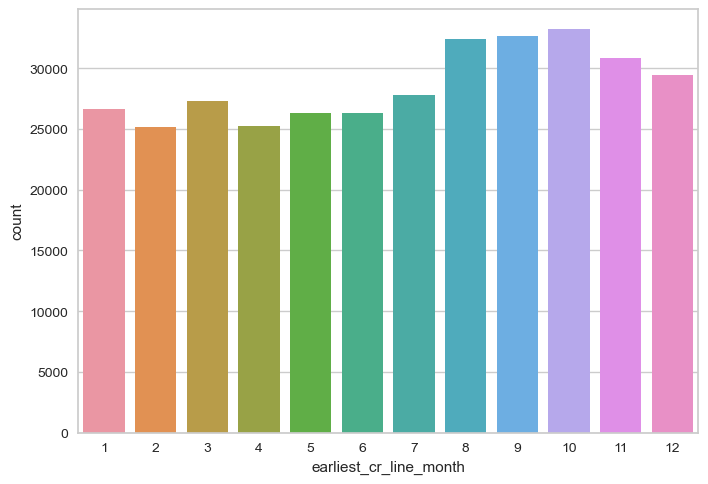

In [450]:
# earliest_cr_line_month

print(data['earliest_cr_line_month'].value_counts())

sns.countplot(data=data,x='earliest_cr_line_month')
plt.show()

### earliest_cr_line_month

- 신용 계좌 개설 월의 분포를 보여줌  
- 전반적으로 **월별로 큰 차이는 없으나**, **8~10월에 개설된 계좌 수가 상대적으로 높음**  
- 2~6월은 비교적 낮은 빈도를 보임


f    207860
w    135373
Name: initial_list_status, dtype: int64


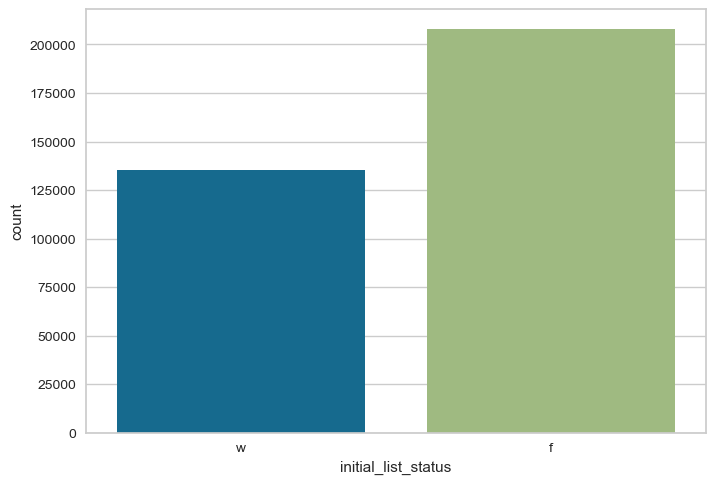

In [451]:
# initial_list_status

print(data['initial_list_status'].value_counts())

sns.countplot(data=data,x='initial_list_status')
plt.show()

### initial_list_status

- 초기 대출 상태(`f`, `w`)의 분포를 나타냄  
- `f` 상태가 약 **207,378건**으로 `w`(135,209건)보다 더 많음  
- 즉, **대부분의 대출이 초기 단계에서 `f` 상태로 분류됨**


INDIVIDUAL    342941
other            292
Name: application_type, dtype: int64


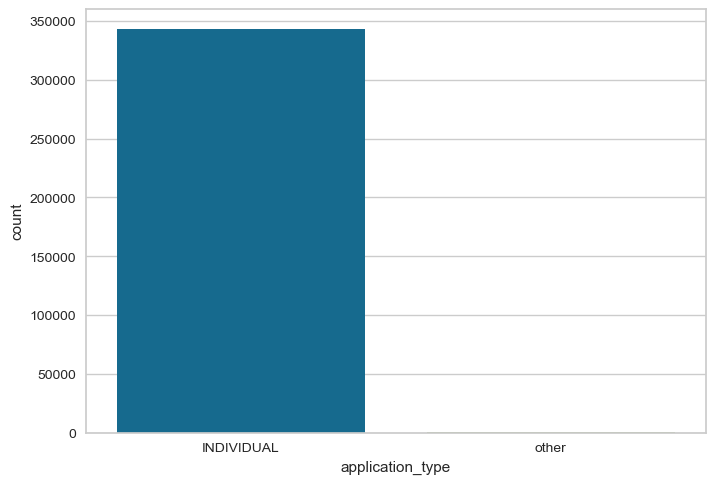

In [452]:
# application_type

def categorize_application_type(x):   # 범주 줄이기
    if(x =='INDIVIDUAL'):
        return x
    return 'other'

data['application_type'] = data['application_type'].apply(categorize_application_type)

print(data['application_type'].value_counts())

sns.countplot(data=data,x='application_type')
plt.show()

### application_type

- **INDIVIDUAL** 유형이 대부분을 차지하며 약 **342,295건**  
- **other** 유형은 292건으로 매우 적음  
- 대출 신청의 형태가 거의 전부 개인 단위로 이루어져 있음


In [453]:
# address

def getPinCode(x):          # 주소에서 우편번호만 추출
    arr = x.split(' ')
    pin = int(arr[-1])
    return pin

data['address'] = data['address'].apply(getPinCode)
data['address']

0         22690
1          5113
2          5113
3           813
4         11650
          ...  
396024     5113
396025    30723
396026     5113
396027    70466
396028    29597
Name: address, Length: 343233, dtype: int64

### address

- **주소 문자열에서 우편번호만 추출**하여 `address` 컬럼에 저장  
- 불필요한 텍스트 정보 대신 **정수형 우편번호만 유지** → 모델에 적합한 형태로 변환


### ⑤ 변수 간 관계 파악

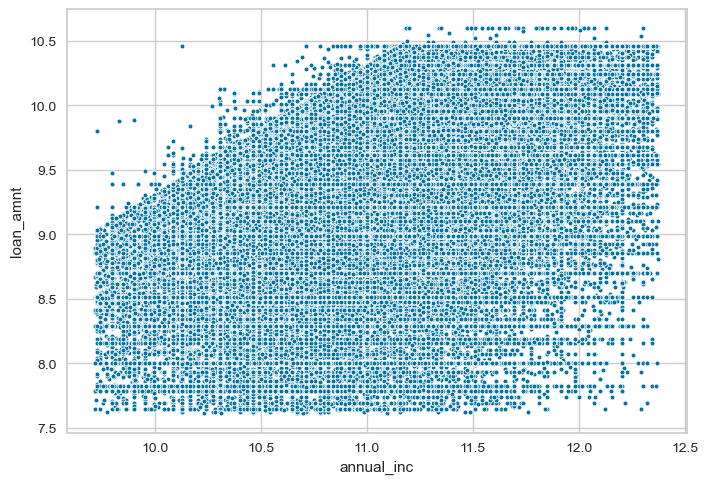

In [454]:
# loan_amnt ↔ annual_inc

sns.scatterplot(y='loan_amnt',x='annual_inc',data=data, marker='.')
plt.show()

### loan_amnt ↔ annual_inc

- `annual_inc`(연소득)과 `loan_amnt`(대출금액) 간의 관계를 산점도로 확인  
- 전반적으로 **소득이 높을수록 대출금액도 커지는 경향**이 보임  
- 일부 구간에서는 소득이 높아도 대출금액이 제한되는 **상한선 패턴**도 존재


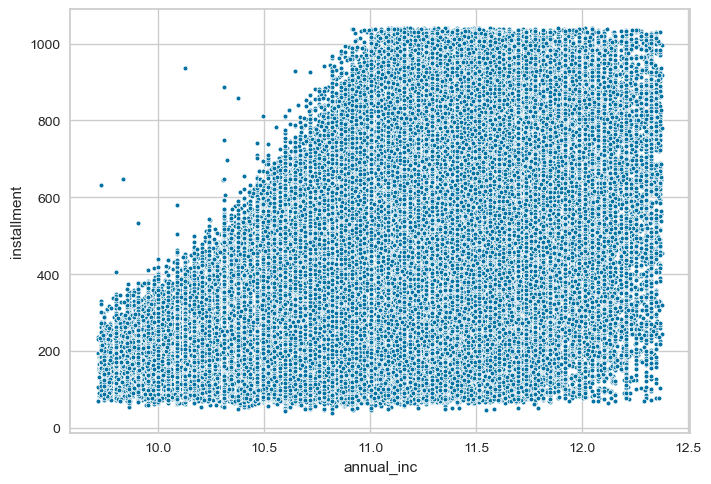

In [455]:
# installment ↔ annual_inc

sns.scatterplot(y='installment',x='annual_inc',data=data, marker='.')
plt.show()

### installment ↔ annual_inc

- `annual_inc`(연소득)과 `installment`(월 상환금액) 간의 관계를 산점도로 확인  
- **소득이 증가할수록 월 상환금액도 커지는 경향**이 뚜렷함  
- 다만 일정 소득 이상에서는 상환금액이 일정 수준(약 1000)에서 **상한선에 도달**하는 모습도 보임


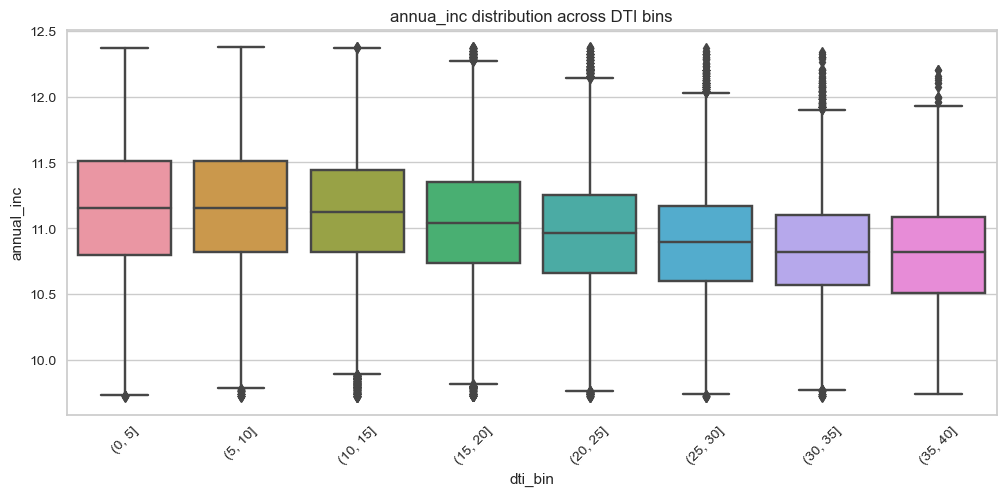

In [456]:
# dti ↔ annual_inc

data['dti_bin'] = pd.cut(data['dti'], bins=range(0, 45, 5)) # DTI를 5 단위 구간으로 나누기

plt.figure(figsize=(12,5))
sns.boxplot(x='dti_bin', y='annual_inc', data=data)
plt.xticks(rotation=45)
plt.title('annua_inc distribution across DTI bins')
plt.show()

### dti ↔ annual_inc

- `dti`(부채 상환 비율)를 5 단위 구간으로 나누고, 각 구간별 `annual_inc`(연소득) 분포를 박스플롯으로 확인  
- **DTI가 낮을수록 연소득의 중앙값이 높고**, 구간이 커질수록 중앙값이 점차 감소하는 경향이 나타남  
- **DTI가 높은 구간에서는 소득 분포의 하위값이 낮아지고**, 전반적으로 소득 수준이 낮은 차이가 뚜렷하게 보임


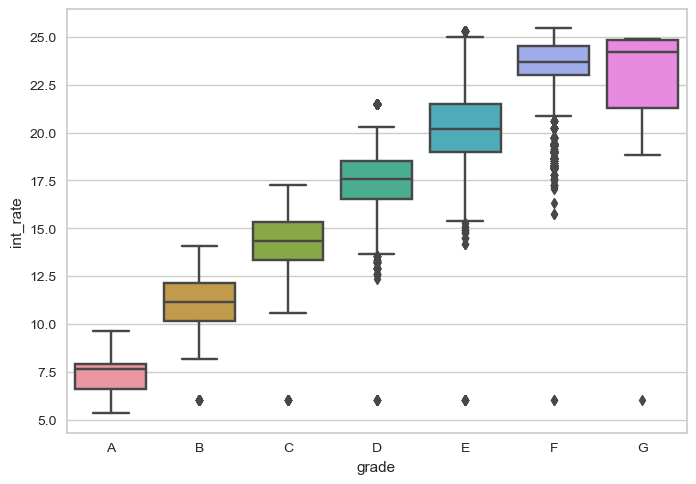

In [457]:
# int_rate ↔ grade

order = sorted(data['grade'].unique())
sns.boxplot(x='grade',y='int_rate',data=data, order=order)
plt.show()

### int_rate ↔ grade

- `grade`(등급)별 `int_rate`(이자율) 분포를 박스플롯으로 확인  
- **등급이 낮을수록(→ G 방향) 이자율이 높아지는 뚜렷한 패턴**이 나타남  
- A 등급의 경우 이자율이 낮고 분포 폭도 좁은 반면, 등급이 내려갈수록 **중앙값과 상·하위 사분위 범위가 모두 증가**  
- 이는 신용등급이 낮은 대출자의 경우 **높은 이자율이 적용됨**을 보여줌


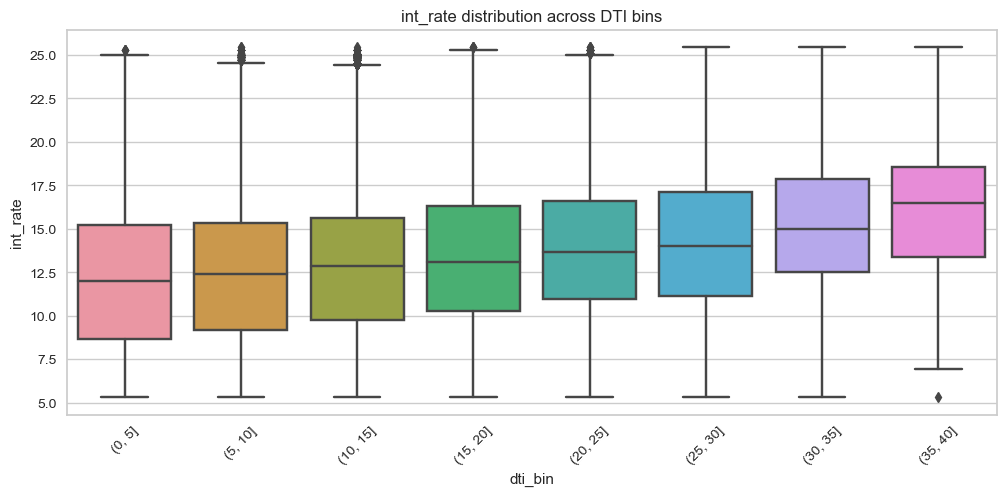

In [458]:
# int_rate ↔ dti

data['dti_bin'] = pd.cut(data['dti'], bins=range(0, 45, 5)) # DTI를 5 단위 구간으로 나누기

plt.figure(figsize=(12,5))
sns.boxplot(x='dti_bin', y='int_rate', data=data)
plt.xticks(rotation=45)
plt.title('int_rate distribution across DTI bins')
plt.show()

### int_rate ↔ dti

- `dti`(부채상환비율)을 구간별(`dti_bin`)로 나누어 `int_rate`(이자율) 분포를 박스플롯으로 확인  
- **DTI가 높아질수록 이자율의 중앙값이 점차 증가하는 경향**을 보임  
- 특히 DTI가 30 이상인 구간에서는 **이자율의 중앙값과 분포의 상단이 뚜렷하게 높아짐**  
- 이는 부채 비율이 높은 대출자에게 **더 높은 금리가 적용되는 경향**을 시각적으로 보여줌


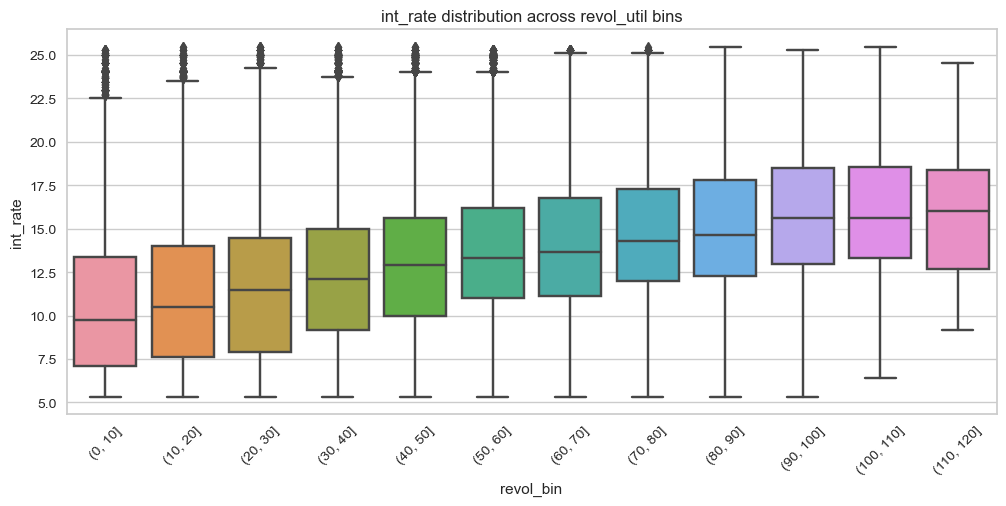

In [459]:
# int_rate ↔ revol_util

data['revol_bin'] = pd.cut(data['revol_util'], bins=range(0, 130, 10))  # 리볼빙 사용률을 10단위로 구간화

plt.figure(figsize=(12,5))
sns.boxplot(x='revol_bin', y='int_rate', data=data)
plt.xticks(rotation=45)
plt.title('int_rate distribution across revol_util bins')
plt.show()

### int_rate ↔ revol_util

- `revol_util`(리볼빙 사용률)을 구간별(`revol_bin`)로 나누어 `int_rate`(이자율) 분포를 박스플롯으로 확인  
- **리볼빙 사용률이 높아질수록 이자율의 중앙값이 점진적으로 상승**하는 패턴이 뚜렷함  
- 특히 사용률이 80% 이상일 때 **이자율의 중앙값이 크게 증가**하며, 분포의 상단도 함께 올라감  
- 이는 신용카드 사용 한도가 많이 소진된 대출자일수록 **더 높은 금리를 부과받는 경향**을 시각적으로 보여줌


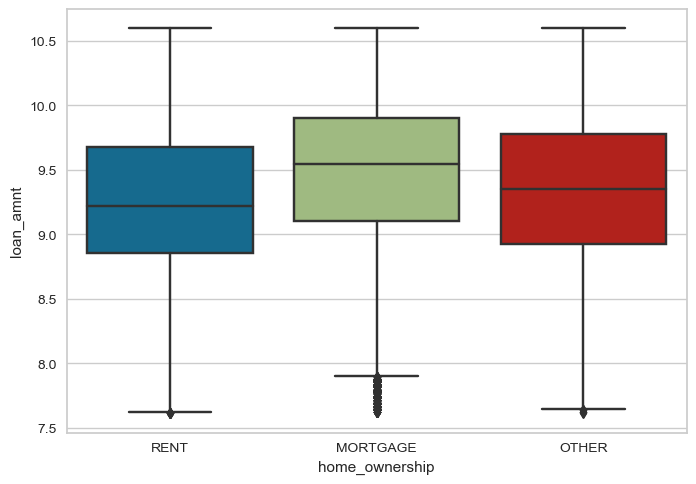

In [460]:
# home_ownership ↔ loan_amnt

sns.boxplot(x='home_ownership',y='loan_amnt',data=data)
plt.show()

### home_ownership ↔ loan_amnt

- `home_ownership`(주택 소유 형태)에 따른 `loan_amnt`(대출 금액)의 분포를 박스플롯으로 비교  
- **MORTGAGE(주택 담보)** 보유자의 대출 금액이 **중앙값 기준 가장 높게 나타남**  
- RENT(임차)와 OTHER 그룹은 상대적으로 비슷한 수준의 대출 금액 분포를 보임  
- 주택을 담보로 제공할 수 있는 경우, **대출 규모가 더 커지는 경향**을 시각적으로 확인할 수 있음


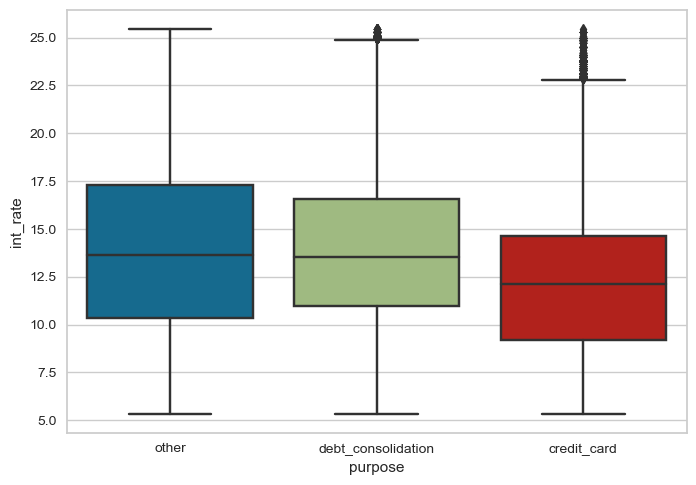

In [461]:
# purpose ↔ int_rate

sns.boxplot(x='purpose',y='int_rate',data=data)
plt.show()

### purpose ↔ int_rate

- `purpose`(대출 목적)에 따른 `int_rate`(이자율) 분포를 박스플롯으로 비교  
- **credit_card** 목적의 대출이 평균적으로 **가장 낮은 금리**를 보임  
- **debt_consolidation**(부채 통합)은 중간 수준, **other**는 상대적으로 높은 금리를 나타냄  
- 이는 대출 목적에 따라 **신용 위험도와 금리 수준이 다르게 책정**됨을 시각적으로 보여줌


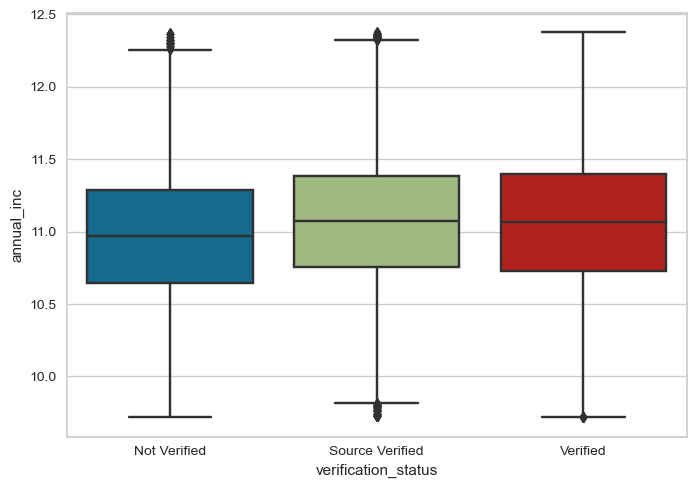

In [462]:
# verification_status ↔ annual_inc

sns.boxplot(x='verification_status',y='annual_inc',data=data)
plt.show()

### verification_status ↔ annual_inc

- `verification_status`(소득 검증 상태)에 따른 `annual_inc`(연소득) 분포를 박스플롯으로 비교  
- **Verified** 및 **Source Verified** 그룹이 **Not Verified**보다 약간 더 높은 연소득 분포를 보임  
- 검증된 소득이 높은 경우가 많다는 점에서, **소득 검증은 대출자의 소득 수준과 일정 부분 연관**이 있음을 시사함


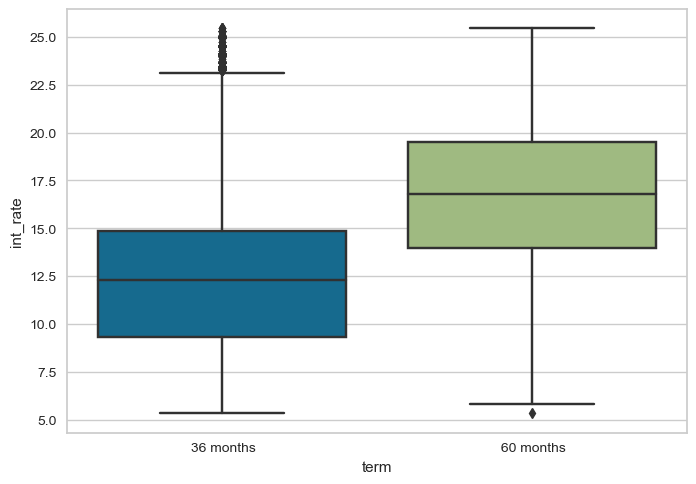

In [463]:
# term ↔ int_rate

sns.boxplot(x='term',y='int_rate',data=data)
plt.show()

### term ↔ int_rate

- `term`(대출 기간)에 따른 `int_rate`(이자율) 분포를 박스플롯으로 비교  
- **60개월 대출**이 **36개월 대출**에 비해 전반적으로 **이자율이 더 높게 분포**함  
- 대출 기간이 길수록 **대출기관의 리스크가 커지기 때문에**, 이를 반영해 **더 높은 금리**가 적용되는 것으로 해석 가능


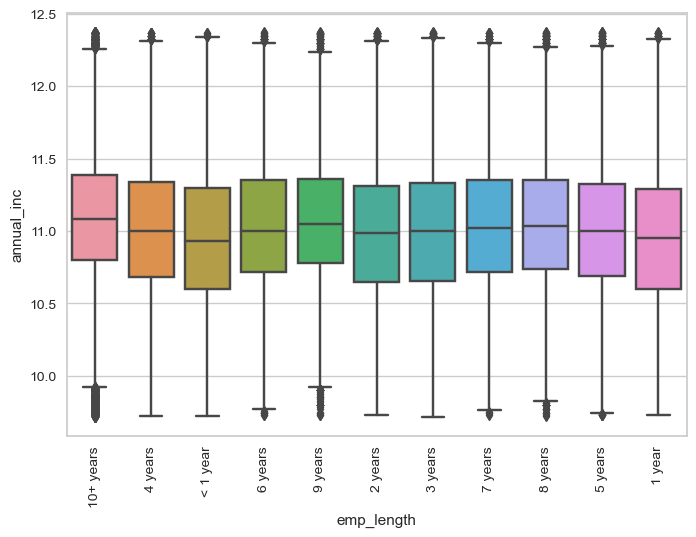

In [464]:
# emp_length ↔ annual_income

sns.boxplot(x='emp_length',y='annual_inc',data=data)
plt.xticks(rotation=90)
plt.show()

### emp_length ↔ annual_inc

- `emp_length`(근속연수)에 따른 `annual_inc`(연소득) 분포를 박스플롯으로 비교  
- 전반적으로 근속연수가 길수록 **연소득의 중앙값이 약간 높아지는 경향**을 확인할 수 있음  
- 특히 **10년 이상 근속자** 그룹이 다른 그룹에 비해 **중앙값이 가장 높음**  
- 다만 전체적으로 근속연수에 따른 소득 차이는 크지 않으며, **근속연수 외의 다른 요인들도 소득에 영향을 미침**을 시사함


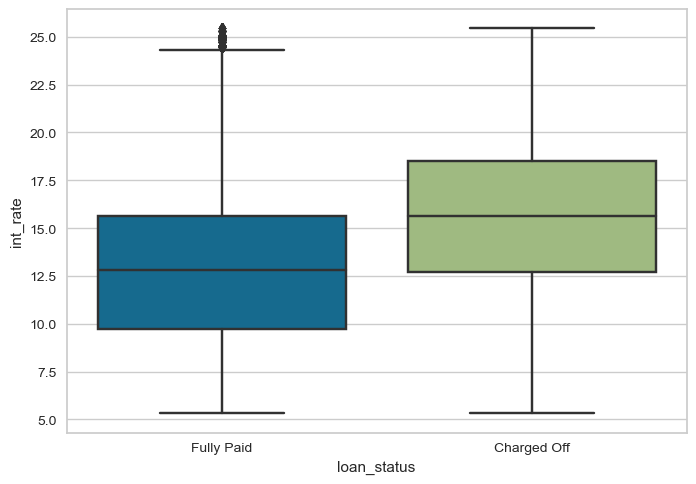

In [465]:
# loan_status ↔ int_rate

sns.boxplot(x='loan_status',y='int_rate',data=data)
plt.show()

### loan_status ↔ int_rate

- `loan_status`(대출 상환 상태)에 따른 `int_rate`(이자율) 분포를 박스플롯으로 비교  
- **연체 및 부실(Charged Off)** 그룹의 이자율 중앙값이 **정상 상환(Fully Paid)** 그룹보다 **명확히 높음**  
- 이는 **이자율이 높은 대출일수록 부실 가능성이 커진다**는 점을 시각적으로 보여줌  
- 또한 Charged Off 그룹의 분포는 전반적으로 **상위 구간에 더 치우쳐 있음**, 이는 리스크 프리미엄과도 관련됨


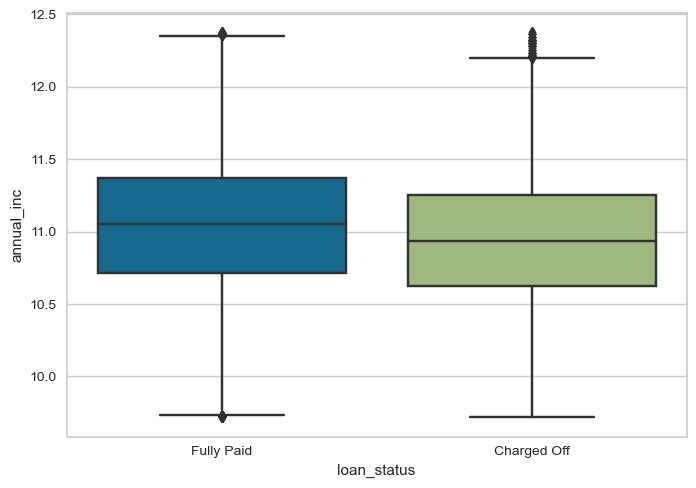

In [466]:
# loan_status ↔ annual_inc

sns.boxplot(x='loan_status',y='annual_inc',data=data)
plt.show()

### loan_status ↔ annual_inc

- `loan_status`(대출 상환 상태)에 따른 `annual_inc`(연소득) 분포를 박스플롯으로 비교  
- **정상 상환(Fully Paid)** 그룹이 **부실(Charged Off)** 그룹보다 연소득의 중앙값이 약간 더 높음  
- 이는 **소득이 높은 차주일수록 상환 능력이 더 우수**하여 부실 확률이 낮아질 수 있음을 시사  
- 두 그룹 모두 전체적인 분포 범위는 비슷하지만, **Charged Off 그룹은 저소득 구간에 더 많은 비중**이 있음


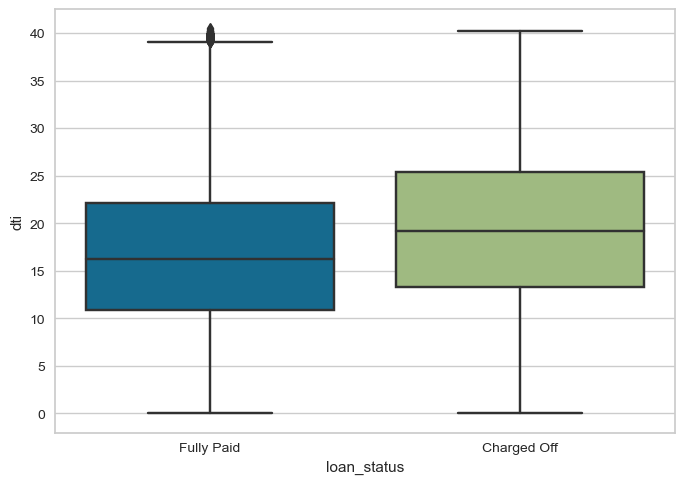

In [467]:
# loan_status ↔ dti

sns.boxplot(x='loan_status',y='dti',data=data)
plt.show()

### loan_status ↔ dti

- `loan_status`(대출 상환 상태)에 따른 `dti`(부채 상환 비율) 분포를 박스플롯으로 비교  
- **부실(Charged Off)** 그룹이 **정상 상환(Fully Paid)** 그룹보다 **DTI의 중앙값이 더 높음**  
- 이는 **부채 부담이 큰 차주일수록 부실 위험이 높아지는 경향**을 잘 보여줌  
- 또한 Charged Off 그룹의 DTI 분포는 전체적으로 더 넓게 퍼져 있으며, 고 DTI 구간의 차주가 더 많음


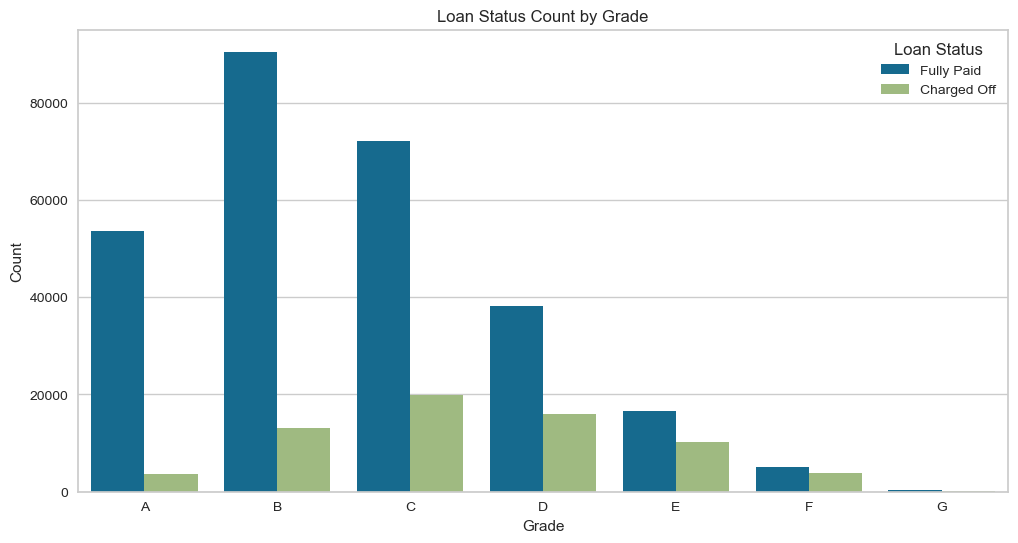

In [468]:
# loan_status ↔ grade

plt.figure(figsize=(12,6))
sns.countplot(x='grade', hue='loan_status', data=data, order=order)
plt.title('Loan Status Count by Grade')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

### loan_status ↔ grade


- **A~C 등급**은 상환 건수가 많고 부실은 상대적으로 적음
- **B 등급**이 상환 규모에서 가장 크며, **C~D 등급**에서는 부실 건수가 눈에 띄게 증가함
- **E~G 등급**은 전체 규모는 작지만, **부실 비중이 높아 고위험군**으로 볼 수 있음


# 2. 피처 엔지니어링

In [469]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'address', 'issue_d_year', 'issue_d_month',
       'earliest_cr_line_year', 'earliest_cr_line_month', 'dti_bin',
       'revol_bin'],
      dtype='object')

In [470]:
data.drop(columns=['dti_bin','revol_bin'],inplace=True)
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'address', 'issue_d_year', 'issue_d_month',
       'earliest_cr_line_year', 'earliest_cr_line_month'],
      dtype='object')

In [471]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'purpose',
       'initial_list_status', 'application_type'],
      dtype='object')


In [472]:
# emp_length: 10년 이상이면 10, 1년 미만이면 0

def empLen(x):
    if(x=='10+ years'):
        return 10
    elif(x=='< 1 year'):
        return 0
    else:
        val = x.split()[0]
        return int(val)

data['emp_length'] = data['emp_length'].apply(empLen)

In [473]:
# 범주형 변수 라벨 인코딩


# 라벨 인코딩할 컬럼 목록 지정
label_cols = ['term', 'grade', 'sub_grade', 'emp_title', 'loan_status', 'initial_list_status', 'application_type']   # 예시

# 각 컬럼에 대해 라벨 인코더 적용
le = LabelEncoder()

for col in label_cols:
    data[col] = le.fit_transform(data[col].astype(str))  # 문자열로 변환 후 인코딩

# One-Hot Encoding 수행

data = pd.get_dummies(data, columns=['home_ownership'], drop_first=True, prefix='home_ownership',prefix_sep='_', dtype=int)
data = pd.get_dummies(data, columns=['verification_status'], drop_first=True, prefix='verification_status',prefix_sep='_', dtype=int)
data = pd.get_dummies(data, columns=['purpose'], drop_first=True, prefix='purpose',prefix_sep='_', dtype=int)

In [474]:
data['loan_status'].value_counts()

1    276287
0     66946
Name: loan_status, dtype: int64

In [475]:
data['loan_status'] = 1-data['loan_status']
data['loan_status'].value_counts()

0    276287
1     66946
Name: loan_status, dtype: int64

- 0: 정상 상환
- 1: 부실 채권

In [476]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,annual_inc,loan_status,...,issue_d_year,issue_d_month,earliest_cr_line_year,earliest_cr_line_month,home_ownership_OTHER,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_debt_consolidation,purpose_other
0,9.210440,0,11.44,329.48,1,8,72799,10,11.669938,0,...,2015,1,1990,6,0,1,0,0,0,1
1,8.987322,0,11.99,265.68,1,9,30023,4,11.082158,0,...,2015,1,2004,7,0,0,0,0,1,0
2,9.655090,0,10.49,506.97,1,7,114190,0,10.670303,0,...,2015,1,2007,8,0,1,1,0,0,0
3,8.881975,0,6.49,220.65,0,1,25038,6,10.896758,0,...,2014,11,2006,9,0,1,0,0,0,0
4,10.101354,1,17.27,609.33,2,14,34524,9,10.915107,1,...,2013,4,1999,3,0,0,0,1,0,0


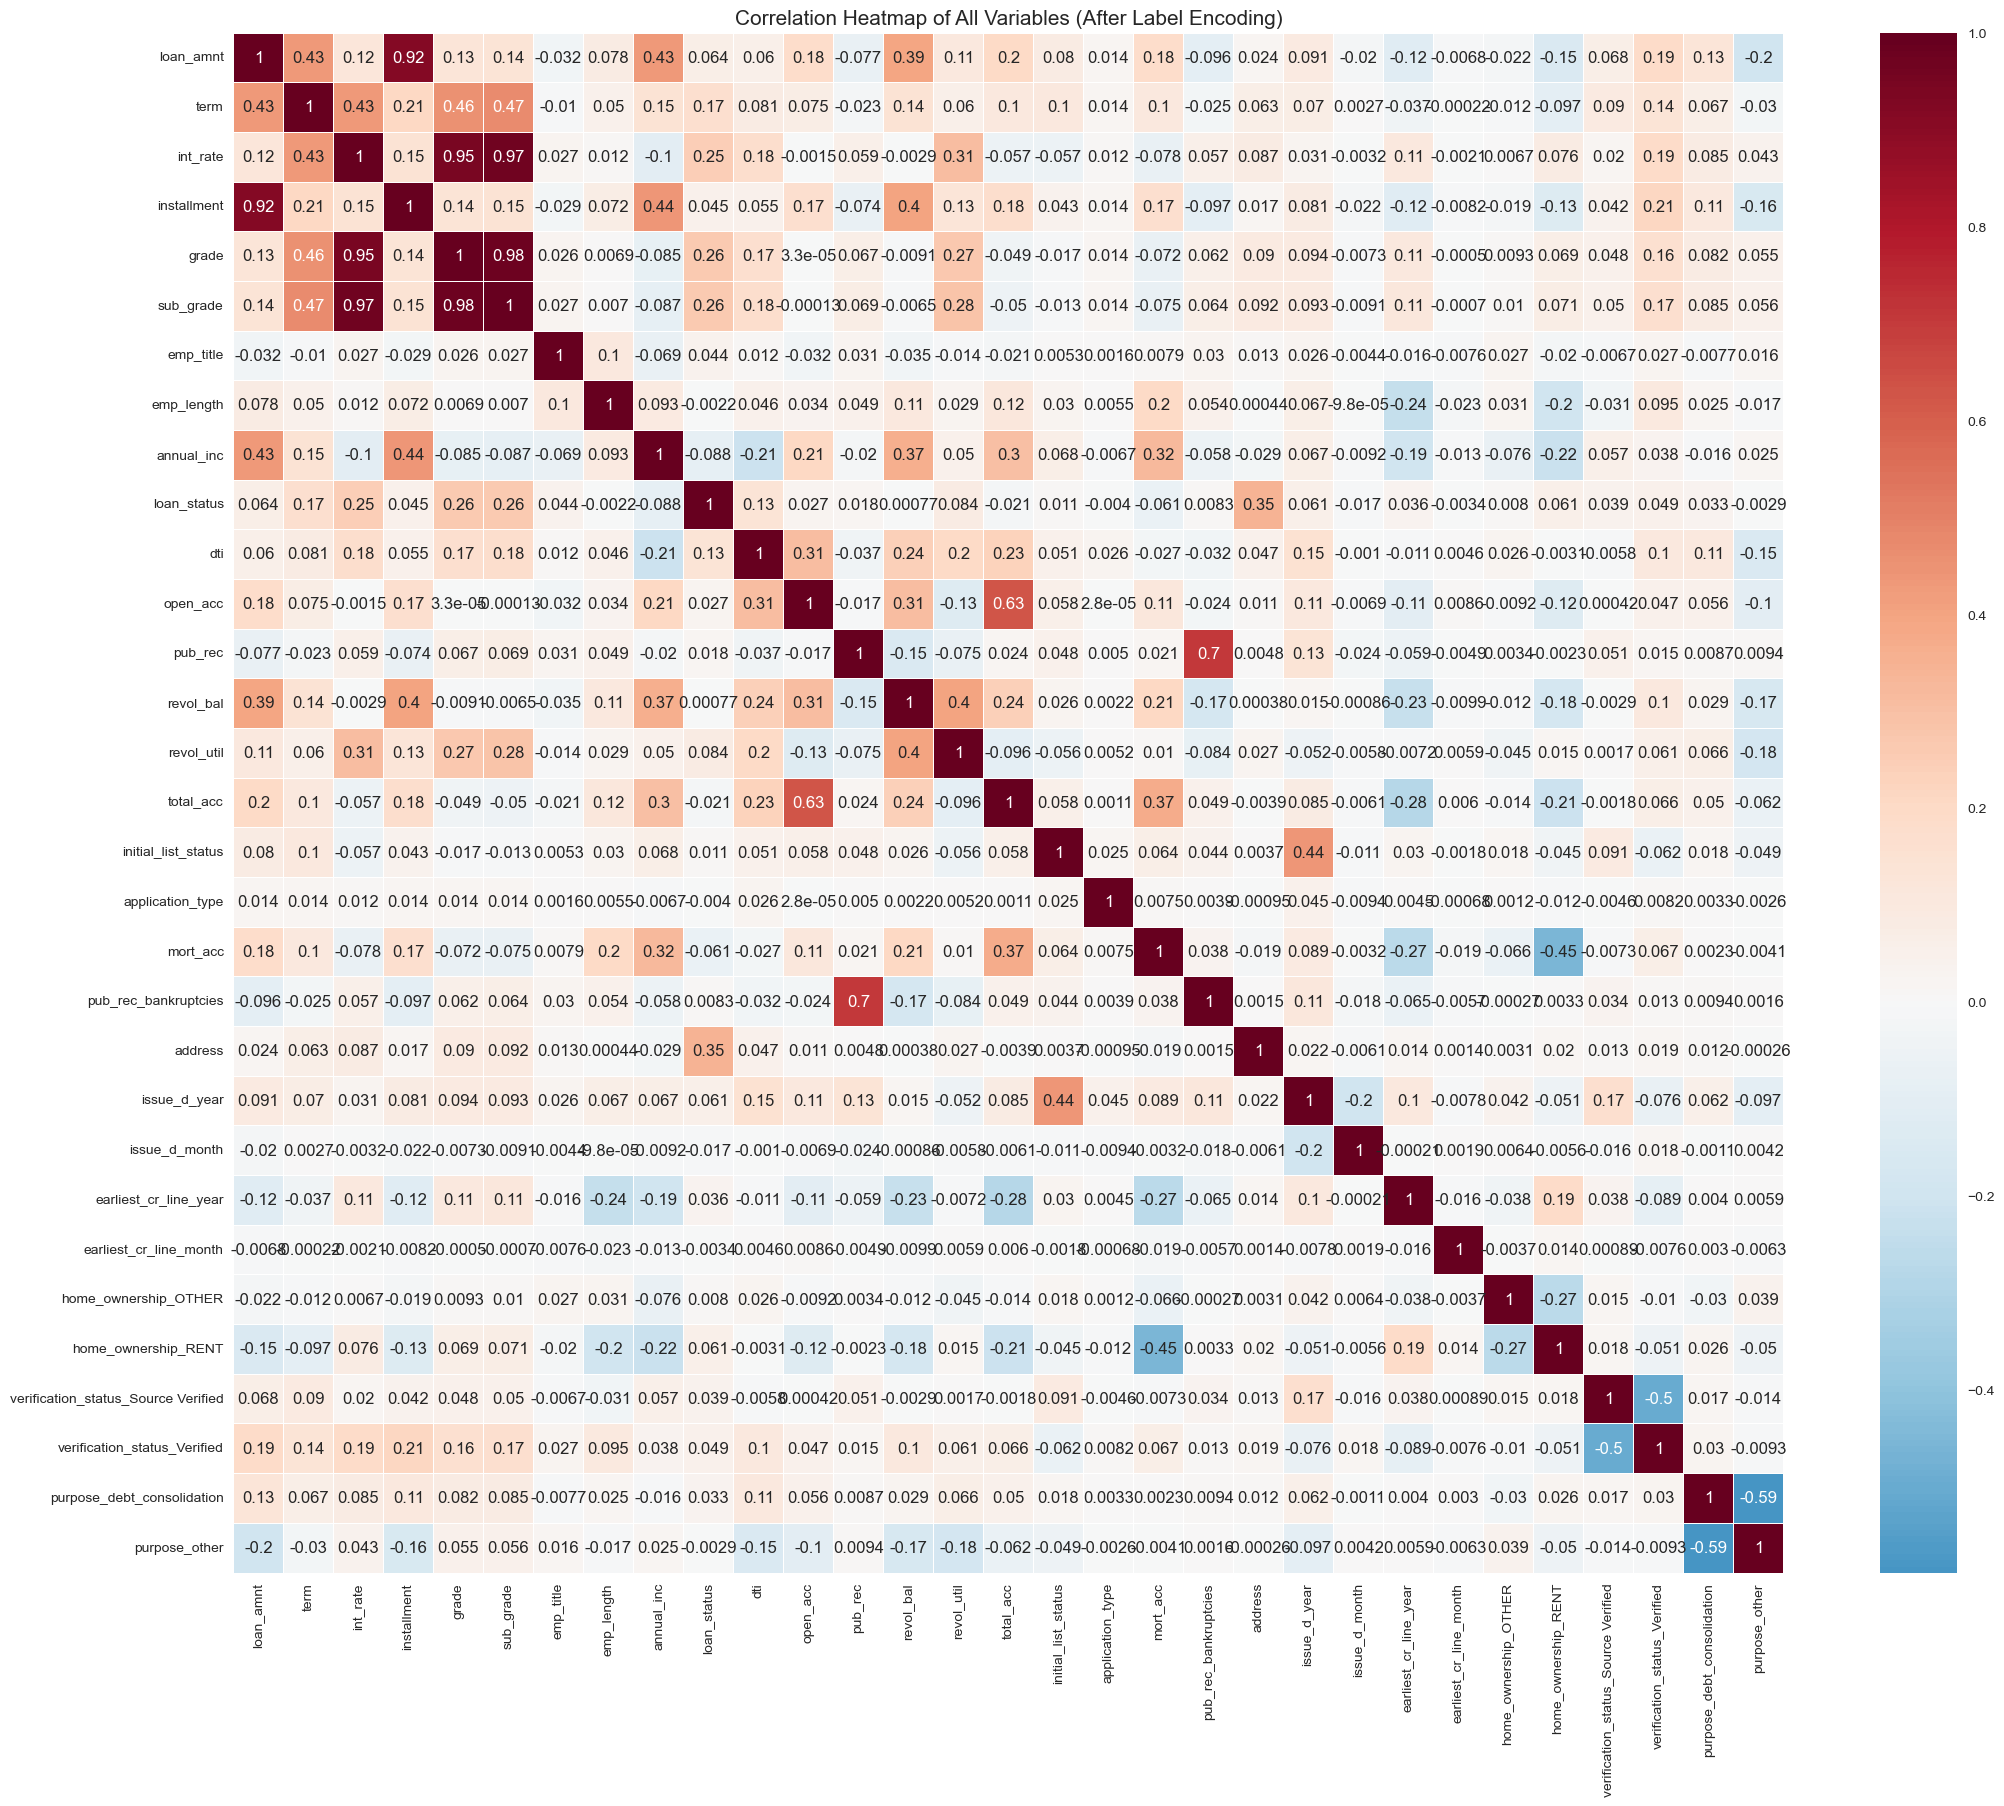

In [477]:
# 상관계수 행렬 계산
corr_matrix = data.corr()

# 히트맵 시각화
plt.figure(figsize=(25, 20))
sns.heatmap(
    corr_matrix,
    cmap='RdBu_r',
    center=0,
    annot=True,     # True로 바꾸면 수치 표시됨 (복잡해질 수 있음)
    linewidths=0.5
)
plt.title('Correlation Heatmap of All Variables (After Label Encoding)', fontsize=15)
plt.show()

In [478]:
# interest_amount = loan_amnt × int_rate
data['interest_amount'] = data['loan_amnt'] * data['int_rate']

# installment_income_ratio = installment / annual_inc
data['installment_income_ratio'] = data['installment'] / data['annual_inc']

# open_to_total_ratio = open_acc / total_acc
data['open_to_total_ratio'] = data['open_acc'] / data['total_acc']

# public_issue_score = pub_rec + pub_rec_bankruptcies
data['public_issue_score'] = data['pub_rec'] + data['pub_rec_bankruptcies']

# 사용된 기존 칼럼 삭제
cols_to_drop = ['loan_amnt', 'int_rate', 'installment', 'annual_inc',
                'open_acc', 'total_acc', 'pub_rec', 'pub_rec_bankruptcies']
data.drop(columns=cols_to_drop, inplace=True)

### 실제 이자부담: `interest_amount`
- `interest_amount = loan_amnt * int_rate`
- 같은 금액이라도 금리가 다르면, 같은 금리라도 금액이 다르면 부담이 달라짐 → 두 변수를 **곱**해 **실제 비용(연 이자액)**을 직접 표현.
- `loan_amnt`, `int_rate`, `installment`가 서로 상관이 높아 **중복 정보**가 많음 → 핵심 신호를 `interest_amount`로 **압축**하고 원천 변수 일부 **제거**.

---

### 소득 대비 상환부담: `installment_income_ratio`
- `installment_income_ratio = installment / annual_inc`
- 동일한 할부액도 **소득 수준**에 따라 부담 강도가 달라짐 → **비율 특징**으로 **개인 간 규모 차이 보정**.
- 신용위험에서 **부채/소득 비율**은 보통 위험과 **단조 관계**(높을수록 위험↑) → **예측력 높은 지표**.

---

### 활동 계좌 비중: `open_to_total_ratio`
- `open_to_total_ratio = open_acc / total_acc`
- 사람마다 계좌 수 자체가 달라 단순 개수만 보면 해석이 어려움 → **비율**로 **활동성/관리 상태의 상대적 수준**을 파악.
- **규모 정규화**로 샘플 간 비교가 쉬워지고 **일반화 성능**에 유리.

---

### 공적 부정 기록의 종합 점수: `public_issue_score`
- `public_issue_score = pub_rec + pub_rec_bankruptcies`
- 두 변수 모두 **희소(대부분 0, 드물게 1+)** → 각각 쓰면 신호가 약함.
- **단순 합**으로 **부정 기록 강도**를 한 축으로 모아 **직관적 위험 지표**를 생성(값이 클수록 위험↑).
- 희소 신호를 결합해 **분산을 줄이고 안정성**을 높임. 겹치는 원천 변수는 **드롭**.


# 3. 머신러닝 모델 구축

In [479]:
x = data.drop(columns=['loan_status','issue_d_month','issue_d_year','earliest_cr_line_month','earliest_cr_line_year', 'emp_title'])
y = pd.DataFrame(data['loan_status'],columns=['loan_status'])

In [480]:
# train, test 데이터 분할

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [481]:
# 데이터 스케일링

scaler = StandardScaler()
cols = ['grade', 'sub_grade','emp_length', 'dti',
        'revol_bal', 'address', 'interest_amount', 'installment_income_ratio', 'open_to_total_ratio',
       'public_issue_score']
x_train[cols] = scaler.fit_transform(x_train[cols])

In [482]:
x.head()

,term,grade,sub_grade,emp_length,dti,revol_bal,revol_util,initial_list_status,application_type,mort_acc,...,home_ownership_OTHER,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_debt_consolidation,purpose_other,interest_amount,installment_income_ratio,open_to_total_ratio,public_issue_score
0,0,1,8,10,26.24,190.706581,41.8,1,0,0.0,...,0,1,0,0,0,1,105.367438,28.233227,0.640000,0.0
1,0,1,9,4,22.05,141.883755,53.3,0,0,3.0,...,0,0,0,0,1,0,107.757989,23.973670,0.629630,0.0
2,0,1,7,0,12.79,109.485159,92.2,0,0,0.0,...,0,1,1,0,0,0,101.281897,47.512239,0.500000,0.0
3,0,0,1,6,2.60,73.972968,21.5,0,0,0.0,...,0,1,0,0,0,0,57.644019,20.249142,0.461538,0.0
4,1,2,14,9,33.95,156.792857,69.8,0,0,1.0,...,0,0,0,1,0,0,174.450389,55.824466,0.302326,0.0


In [483]:
# 다중공선성 제거

from statsmodels.tools import add_constant   # 상수항(intercept) 추가
from statsmodels.stats.outliers_influence import variance_inflation_factor

new_vif = pd.DataFrame()
new_x_t = x_train
new_x_t = add_constant(new_x_t)
new_vif['features'] = new_x_t.columns
for col in new_x_t.select_dtypes(include=['bool']).columns:
    new_x_t[col] = new_x_t[col].astype(int)
new_vif['vif'] = [variance_inflation_factor(new_x_t.values, i) for i in range(new_x_t.shape[1])]
print(new_vif)


                               features        vif
0                                 const  21.560850
1                                  term   1.535566
2                                 grade  20.922340
3                             sub_grade  38.524208
4                            emp_length   1.083117
5                                   dti   1.143415
6                             revol_bal   1.644192
7                            revol_util   1.471900
8                   initial_list_status   1.071172
9                      application_type   1.001885
10                             mort_acc   1.519669
11                              address   1.011036
12                 home_ownership_OTHER   1.143417
13                  home_ownership_RENT   1.482159
14  verification_status_Source Verified   1.450454
15         verification_status_Verified   1.550529
16           purpose_debt_consolidation   1.589554
17                        purpose_other   1.720733
18                      interes

In [484]:
x_train.drop(columns = ['sub_grade'], inplace = True)

new_vif = pd.DataFrame()
new_x_t = x_train
new_x_t = add_constant(new_x_t)
new_vif['features'] = new_x_t.columns
for col in new_x_t.select_dtypes(include=['bool']).columns:
    new_x_t[col] = new_x_t[col].astype(int)
new_vif['vif'] = [variance_inflation_factor(new_x_t.values, i) for i in range(new_x_t.shape[1])]
print(new_vif)

                               features        vif
0                                 const  21.486871
1                                  term   1.532047
2                                 grade  10.125754
3                            emp_length   1.082589
4                                   dti   1.141826
5                             revol_bal   1.643946
6                            revol_util   1.471855
7                   initial_list_status   1.056453
8                      application_type   1.001876
9                              mort_acc   1.519424
10                              address   1.010800
11                 home_ownership_OTHER   1.143133
12                  home_ownership_RENT   1.481666
13  verification_status_Source Verified   1.444237
14         verification_status_Verified   1.550135
15           purpose_debt_consolidation   1.587214
16                        purpose_other   1.708645
17                      interest_amount  12.061932
18             installment_inco

In [485]:
x_test[cols] = scaler.transform(x_test[cols])
x_test.drop(columns='sub_grade',inplace=True)

In [486]:
x_train = sm.add_constant(x_train)
for col in x_train.select_dtypes(include=['bool']).columns:
    x_train[col] = x_train[col].astype(int)
x_test = sm.add_constant(x_test)
for col in x_test.select_dtypes(include=['bool']).columns:
    x_test[col] = x_test[col].astype(int)
y_train = y_train["loan_status"].values
y_test = y_test["loan_status"].values

In [185]:
# 최적 모델 선정

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc')
    results[name] = np.mean(scores)

sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print("Model Performance (AUC):")
for name, score in sorted_results:
    print(f"{name:<25}: {score:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 176851, number of negative: 42817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1595
[LightGBM] [Info] Number of data points in the train set: 219668, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.805083 -> initscore=1.418372
[LightGBM] [Info] Start training from score 1.418372
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 176851, number of negative: 42818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

- LightGBM과 Gradient Boosting 두 가지 모델 활용

# 4. 모델 학습·예측·성능평가

## ① LightGBM

In [487]:
# lightGBM

model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

model.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 53522, number of negative: 221064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1593
[LightGBM] [Info] Number of data points in the train set: 274586, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194919 -> initscore=-1.418359
[LightGBM] [Info] Start training from score -1.418359


LGBMClassifier(learning_rate=0.05, n_estimators=500, random_state=42)

In [488]:
y_train_pred = model.predict(x_train)

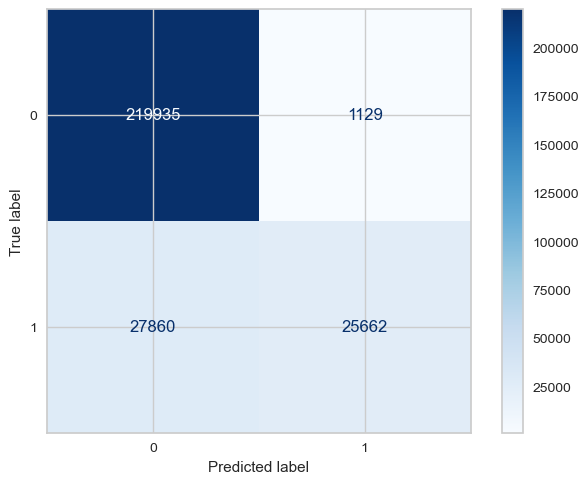

In [489]:
# Confusion Matrix

cm = confusion_matrix(y_train,y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

- 0: 정상 상환
- 1: 부실 대출

In [490]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    221064
           1       0.96      0.48      0.64     53522

    accuracy                           0.89    274586
   macro avg       0.92      0.74      0.79    274586
weighted avg       0.90      0.89      0.88    274586



In [491]:
y_test_pred = model.predict(x_test)

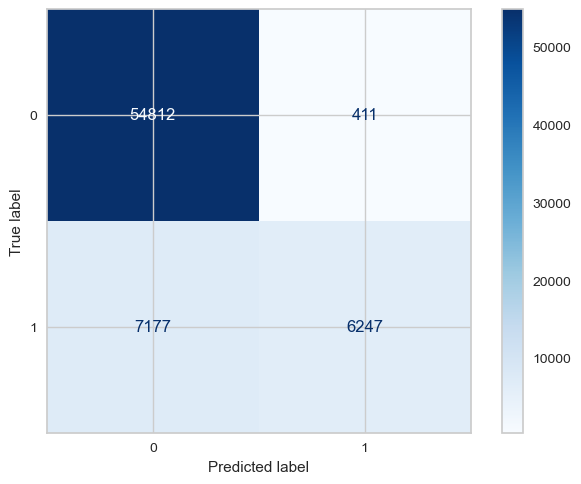

In [492]:
# Confusion Matrix

cm = confusion_matrix(y_test,y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [493]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     55223
           1       0.94      0.47      0.62     13424

    accuracy                           0.89     68647
   macro avg       0.91      0.73      0.78     68647
weighted avg       0.89      0.89      0.87     68647



Accuracy : 0.8894634871152417
recall_score : 0.4653605482717521
precision_score : 0.9382697506758786
f1_score : 0.6221491883278558
AUC score : 0.905700793124041


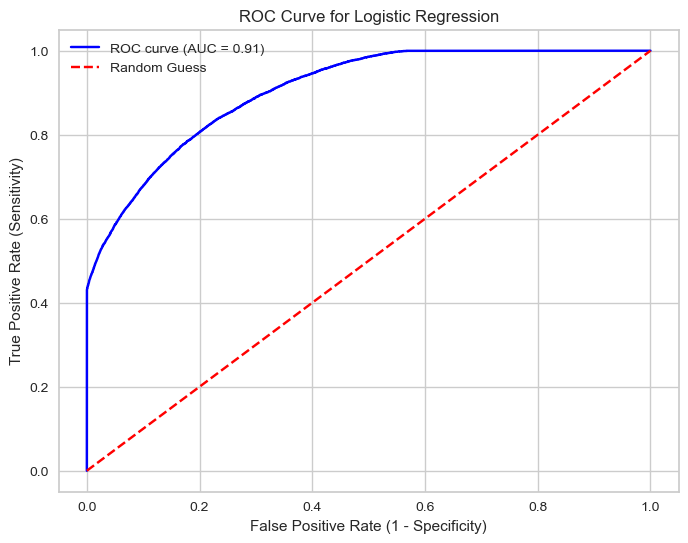

In [494]:
# ROC Curve 생성

print("Accuracy :",metrics.accuracy_score(y_test, y_test_pred))
print("recall_score :", metrics.recall_score(y_test, y_test_pred))
print("precision_score :", metrics.precision_score(y_test, y_test_pred))
print("f1_score :" ,metrics.f1_score(y_test, y_test_pred))

y_test_pred_proba = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
auc_score = roc_auc_score(y_test, y_test_pred_proba)
print("AUC score :" ,metrics.roc_auc_score( y_test, y_test_pred_proba))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.grid(True)

## ② Gradient Boosting

In [495]:
# Gradient Boosting

gb_model = GradientBoostingClassifier(
    n_estimators=300,       # 트리 개수
    learning_rate=0.05,    # 학습률 (낮출수록 더 부드러운 학습)
    max_depth=3,          # 트리 최대 깊이
    random_state=42
)

# 학습
gb_model.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,
                           random_state=42)

In [496]:
y_train_pred = gb_model.predict(x_train)

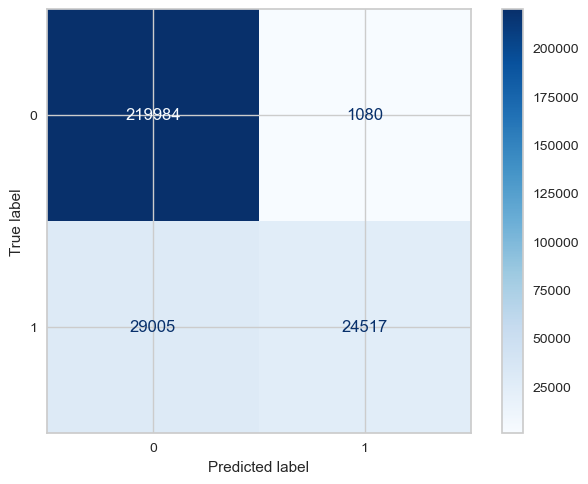

In [497]:
# Confusion Matrix

cm = confusion_matrix(y_train,y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [498]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94    221064
           1       0.96      0.46      0.62     53522

    accuracy                           0.89    274586
   macro avg       0.92      0.73      0.78    274586
weighted avg       0.90      0.89      0.87    274586



In [499]:
y_test_pred = gb_model.predict(x_test)

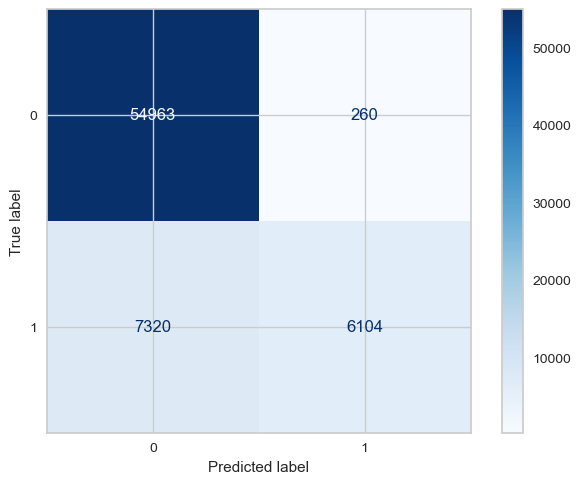

In [500]:
# Confusion Matrix

cm = confusion_matrix(y_test,y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [501]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     55223
           1       0.96      0.45      0.62     13424

    accuracy                           0.89     68647
   macro avg       0.92      0.72      0.78     68647
weighted avg       0.90      0.89      0.87     68647



Accuracy : 0.8895800253470654
recall_score : 0.4547079856972586
precision_score : 0.9591451917033312
f1_score : 0.6169395593288862
AUC score : 0.9055647771295566


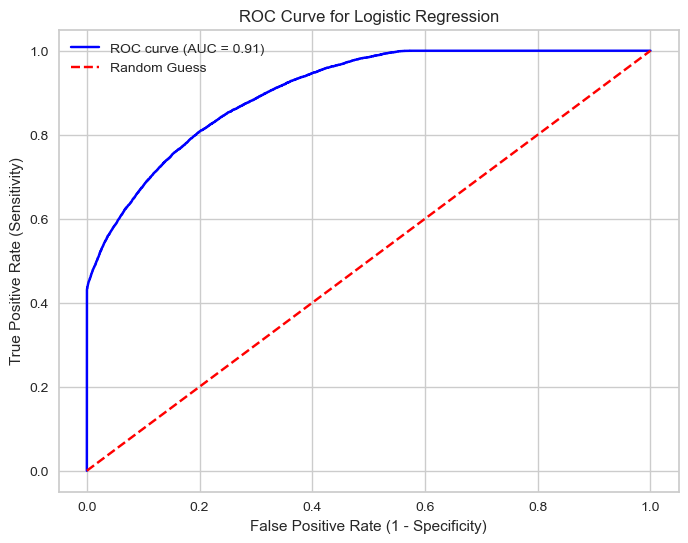

In [502]:
# ROC Curve 생성

print("Accuracy :",metrics.accuracy_score(y_test, y_test_pred))
print("recall_score :", metrics.recall_score(y_test, y_test_pred))
print("precision_score :", metrics.precision_score(y_test, y_test_pred))
print("f1_score :" ,metrics.f1_score(y_test, y_test_pred))

y_test_pred_proba = gb_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
auc_score = roc_auc_score(y_test, y_test_pred_proba)
print("AUC score :" ,metrics.roc_auc_score( y_test, y_test_pred_proba))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.grid(True)

## Imbalanced Data -> SMOTH

In [503]:
# 데이터 불균형-SMOTH

smoth = SMOTE()
x,y = smoth.fit_resample(x,y)

In [504]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
scaler = StandardScaler()
cols = ['grade','sub_grade','emp_length', 'dti',
        'revol_bal', 'address', 'interest_amount', 'installment_income_ratio', 'open_to_total_ratio',
       'public_issue_score']
x_train[cols] = scaler.fit_transform(x_train[cols])
x_train[cols].drop(columns='sub_grade',inplace=True)
x_test[cols] = scaler.transform(x_test[cols])
x_test[cols].drop(columns='sub_grade',inplace=True)
x_train = sm.add_constant(x_train)

for col in x_train.select_dtypes(include=['bool']).columns:
    x_train[col] = x_train[col].astype(int)
x_test = sm.add_constant(x_test)
for col in x_test.select_dtypes(include=['bool']).columns:
    x_test[col] = x_test[col].astype(int)
y_train = y_train["loan_status"].values
y_test = y_test["loan_status"].values

## ③ LightGBM(SMOTH)

In [505]:
# LightGBM

model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)


model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_train_pred

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 221116, number of negative: 220943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 442059, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500196 -> initscore=0.000783
[LightGBM] [Info] Start training from score 0.000783


array([1, 0, 0, ..., 1, 0, 1])

In [506]:
y_train_pred = model.predict(x_train)
y_train_pred

array([1, 0, 0, ..., 1, 0, 1])

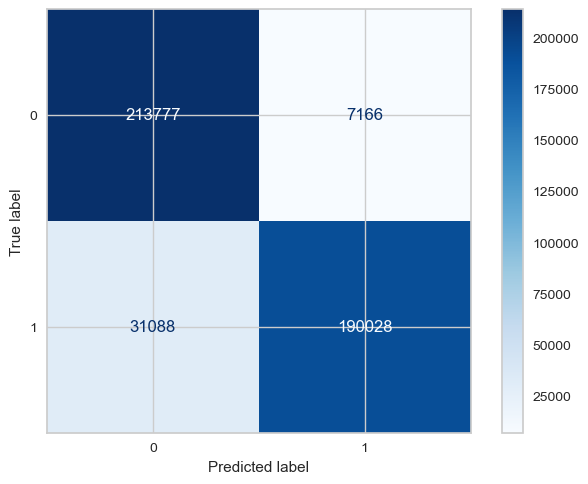

In [507]:
# Confusion Matrix

cm = confusion_matrix(y_train,y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [508]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92    220943
           1       0.96      0.86      0.91    221116

    accuracy                           0.91    442059
   macro avg       0.92      0.91      0.91    442059
weighted avg       0.92      0.91      0.91    442059



In [509]:
y_test_pred = model.predict(x_test)

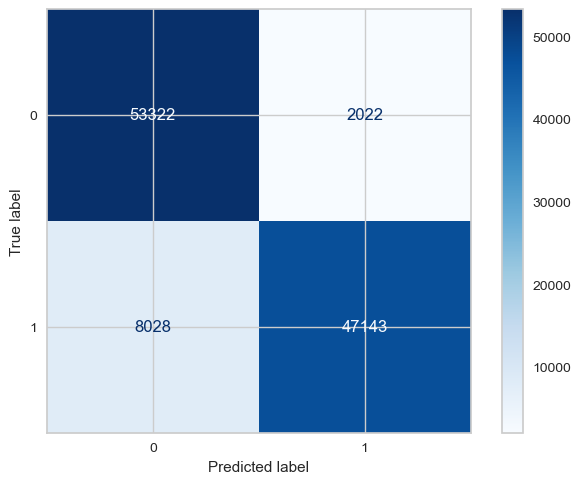

In [510]:
# Confusion Matrix

cm = confusion_matrix(y_test,y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [511]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     55344
           1       0.96      0.85      0.90     55171

    accuracy                           0.91    110515
   macro avg       0.91      0.91      0.91    110515
weighted avg       0.91      0.91      0.91    110515



Accuracy : 0.909062118264489
recall_score : 0.854488771274764
precision_score : 0.9588731821417675
f1_score : 0.9036765833461126
AUC score : 0.9707442358547059


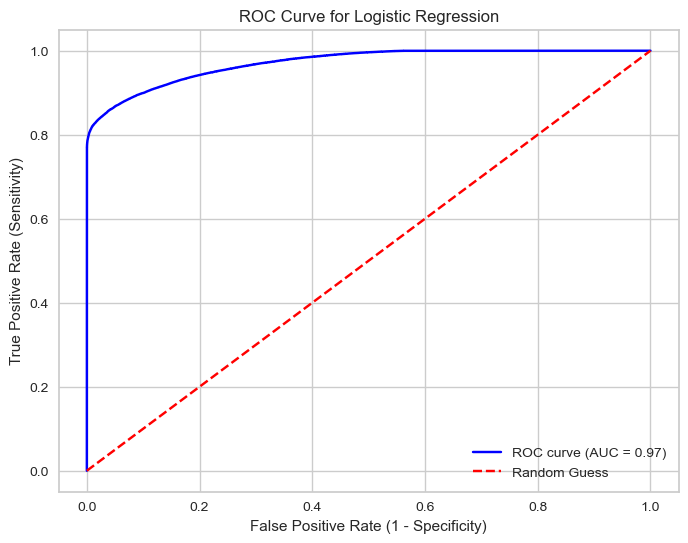

In [512]:
# ROC Curve 생성

print("Accuracy :",metrics.accuracy_score(y_test, y_test_pred))
print("recall_score :", metrics.recall_score(y_test, y_test_pred))
print("precision_score :", metrics.precision_score(y_test, y_test_pred))
print("f1_score :" ,metrics.f1_score(y_test, y_test_pred))

y_test_pred_proba = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
auc_score = roc_auc_score(y_test, y_test_pred_proba)
print("AUC score :" ,metrics.roc_auc_score( y_test, y_test_pred_proba))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.grid(True)

## ④ Gradient Boosting(SMOTH)

In [513]:
# Gradient Boosting

gb_model = GradientBoostingClassifier(
    n_estimators=300,       # 트리 개수
    learning_rate=0.05,    # 학습률 (낮출수록 더 부드러운 학습)
    max_depth=3,          # 트리 최대 깊이
    random_state=42
)

# 학습
gb_model.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,
                           random_state=42)

In [514]:
y_train_pred = gb_model.predict(x_train)
y_train_pred

array([1, 0, 0, ..., 1, 0, 1])

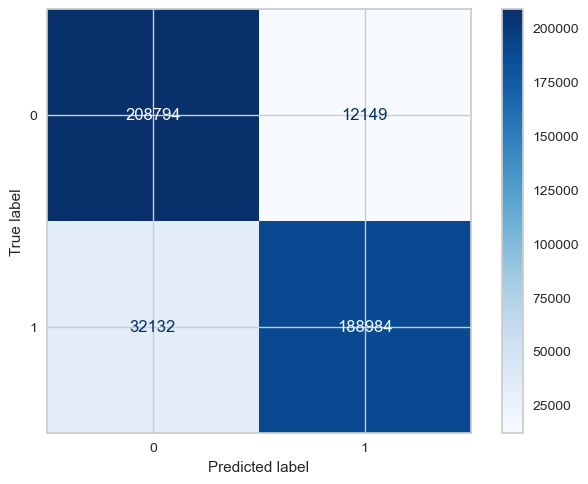

In [515]:
cm = confusion_matrix(y_train,y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [516]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.90    220943
           1       0.94      0.85      0.90    221116

    accuracy                           0.90    442059
   macro avg       0.90      0.90      0.90    442059
weighted avg       0.90      0.90      0.90    442059



In [517]:
y_test_pred = gb_model.predict(x_test)

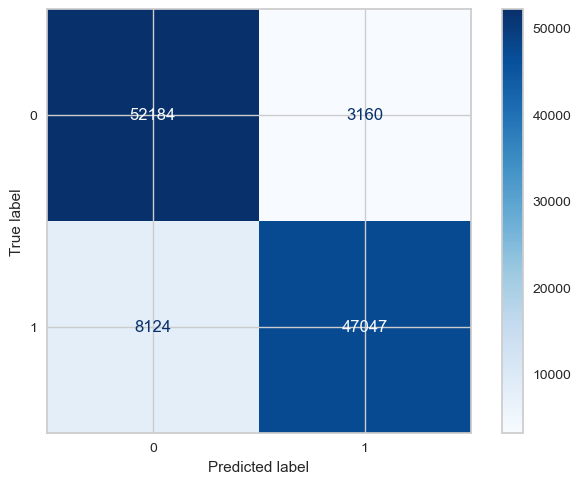

In [518]:
# Confusion Matrix

cm = confusion_matrix(y_test,y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [519]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     55344
           1       0.94      0.85      0.89     55171

    accuracy                           0.90    110515
   macro avg       0.90      0.90      0.90    110515
weighted avg       0.90      0.90      0.90    110515



Accuracy : 0.8978962131837307
recall_score : 0.8527487266861213
precision_score : 0.9370605692433326
f1_score : 0.8929188255613126
AUC score : 0.9652392772681433


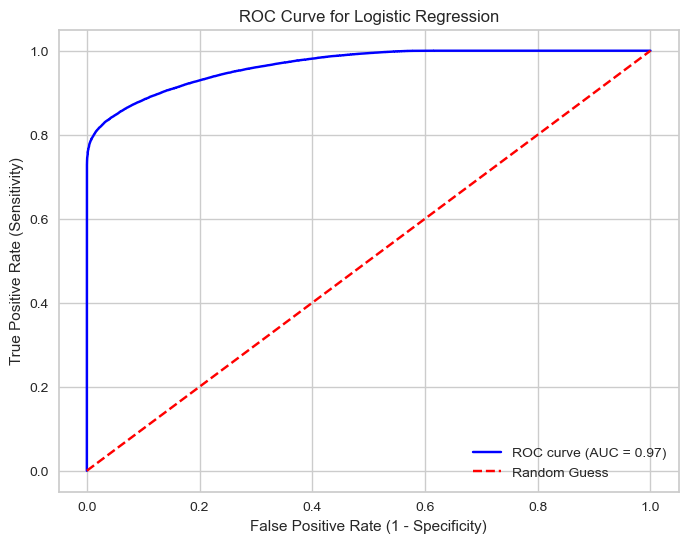

In [520]:
# ROC Curve 생성

print("Accuracy :",metrics.accuracy_score(y_test, y_test_pred))
print("recall_score :", metrics.recall_score(y_test, y_test_pred))
print("precision_score :", metrics.precision_score(y_test, y_test_pred))
print("f1_score :" ,metrics.f1_score(y_test, y_test_pred))

y_test_pred_proba = gb_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
auc_score = roc_auc_score(y_test, y_test_pred_proba)
print("AUC score :" ,metrics.roc_auc_score( y_test, y_test_pred_proba))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.grid(True)